In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from textblob import TextBlob
from scipy.stats import f_oneway
from scipy.stats import norm, shapiro, chi2_contingency
from IPython.display import display
from deep_translator import GoogleTranslator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

In [41]:
# Load the input
data = pd.read_excel('../input/questionnaire.xlsx')

In [3]:
# Clean up text to remove unwanted characters and whitespace
def clean_text(text):
    """
    Cleans text by stripping whitespace and removing new line characters.
    """
    if isinstance(text, str):
        return text.strip().replace("\n", "")
    return text

In [4]:
# Generate a mapping of columns to question descriptions
def generate_column_mapping(input_data):
    """
    Generates a mapping of columns to question descriptions using an explicit
    index-to-question mapping. This function is designed to handle grouped questions
    and dynamically adapt to changes in the questionnaire structure.
    """
    # Explicit mapping of column indices (1-based) to question numbers
    index_to_question = {
        1: 1,  # Column 1 → Question 1
        2: 2,  # Column 2 → Question 2
        3: 3,  # Column 3 → Question 3
        4: 4,
        5: 5,
        6: 6,
        7: 6,
        8: 6,
        9: 6,
        10: 6,
        11: 7,
        12: 8,
        13: 9,
        14: 10,
        15: 11,
        16: 12,
        17: 13,
        18: 14,
        19: 15,
        20: 16,
        21: 17,
        22: 18,
        23: 19,
        24: 20,
        25: 20,
        26: 20,
        27: 20,
        28: 21
    }

    column_mapping = {}

    # Descriptions for grouped questions (Question 6 & Question 20)
    question_6_description = "Πόσο εμπιστεύεστε την τεχνητή νοημοσύνη στις ακόλουθες εφαρμογές;"
    question_20_description = "Πώς θα αξιολογούσατε την τεχνητή νοημοσύνη σε σχέση με τους ανθρώπους στις ακόλουθες πτυχές;"

    # Iterate over columns (index starting at 1) to build the mapping
    for idx, column in enumerate(input_data.columns, start=1):
        question_number = index_to_question.get(idx)

        if question_number == 6:
            # Grouped sub-questions under Question 6
            column_mapping[idx] = (
                f"Question 6\n{question_6_description}\n{clean_text(column)}"
            )
        elif question_number == 20:
            # Grouped sub-questions under Question 20
            column_mapping[idx] = (
                f"Question 20\n{question_20_description}\n{clean_text(column)}"
            )
        else:
            # Default behaviour for standalone questions
            column_mapping[idx] = f"Question {question_number}\n{clean_text(column)}"

    return column_mapping

In [5]:
# Analyze questions and process responses
def analyze_questions(input_data, column_mapping):
    """
    Processes and analyses the input for each question.
    Handles single and multi-answer questions appropriately.
    Uses 'column_mapping' to retrieve question numbers and descriptions.
    Returns a list of tuples: (question_num, question_text, answers).
    """
    results = []

    # Create a reverse mapping: question_number -> [(col_idx, question_text), ...]
    question_to_columns = {}
    for col_idx, question_text in column_mapping.items():
        # Extract question number (e.g. "Question 12\n..." → 12)
        question_number = int(question_text.split("\n")[0].replace("Question ", "").strip())
        question_to_columns.setdefault(question_number, []).append((col_idx, question_text))

    # Process each question number
    for question_number, columns in question_to_columns.items():
        combined_answers = None
        # Use the first column's text as the "question text"
        question_text = columns[0][1]

        # Process each column associated with this question
        for column_idx, _ in columns:
            # Convert from 1-based to 0-based index to retrieve actual column
            column_name = input_data.columns[column_idx - 1]

            # Analyse the column
            if input_data[column_name].dtype == 'object':
                # Possibly multi-answer if there are semicolons
                if input_data[column_name].str.contains(';').any():
                    # Split and flatten multi-answer responses
                    answers = (
                        input_data[column_name]
                        .dropna()
                        .str.split(';')
                        .explode()
                        .apply(clean_text)
                        .value_counts()
                    )
                else:
                    # Single-answer question with text-based responses
                    answers = input_data[column_name].dropna().apply(clean_text).value_counts()
            else:
                # Numeric or other input types
                answers = input_data[column_name].value_counts()

            # Combine answers for grouped questions
            if combined_answers is None:
                combined_answers = answers
            else:
                combined_answers = combined_answers.add(answers, fill_value=0)

        # Clean the index name
        combined_answers.index.name = None

        # Add to results
        results.append((f"Question {question_number}", question_text, combined_answers))

    return results

In [6]:
# Generate descriptive statistics for each question
def generate_statistics(analysis_results):
    """
    Generates descriptive statistics for each question from the analysis results:
    - Total responses
    - Percentage distribution
    - Most common response
    - If numeric, attempts to compute mean/median
    """
    for question_num, question_text, answers in analysis_results:
        print(question_text)
        print("-" * 50)

        # Total responses for this question
        total_responses = answers.sum()
        print(f"Total Responses: {total_responses}")

        # Percentage distribution
        percentages = (answers / total_responses * 100).round(2)
        print("\nPercentage Distribution:")
        print(percentages.to_string())

        # Most common response
        most_common = answers.idxmax()
        print(f"\nMost Common Response: {most_common} ({answers[most_common]} responses)")

        # If numeric-like responses, attempt to compute mean & median
        try:
            numeric_index = pd.to_numeric(answers.index, errors='coerce')
            if numeric_index.notna().all():
                # Weighted mean
                weighted_mean = (numeric_index * answers).sum() / total_responses
                # Weighted median
                repeated_idx = numeric_index.repeat(answers)
                median_response = repeated_idx.median()
                print(f"Mean Response: {weighted_mean:.2f}")
                print(f"Median Response: {median_response:.2f}")
        except Exception:
            print("Mean and Median not applicable (non-numeric responses).")

        print("-" * 50)
        print()

In [7]:
def perform_chi_square(input_data, column1, column2):
    """
    Performs a chi-square test of independence between two categorical variables.
    """
    contingency_table = pd.crosstab(input_data[column1], input_data[column2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic: {chi2:.3f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-Value: {p:.5f}")
    print("Expected Frequencies:")
    print(expected)

In [8]:
def calculate_confidence_interval(data_series, confidence=0.95):
    """
    Calculates the confidence interval for the mean of a numeric Series.
    """
    mean_val = np.mean(data_series)
    std_err = np.std(data_series, ddof=1) / np.sqrt(len(data_series))
    z_value = norm.ppf((1 + confidence) / 2)  # Z for two-tailed
    margin_of_error = z_value * std_err
    lower_bound = mean_val - margin_of_error
    upper_bound = mean_val + margin_of_error
    print(f"Mean: {mean_val:.2f}")
    print(f"{int(confidence * 100)}% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

In [9]:
def calculate_correlation(input_data, column1, column2):
    """
    Calculates the Pearson correlation coefficient between two numeric columns.
    """
    correlation = input_data[column1].corr(input_data[column2])
    print(f"Pearson Correlation Coefficient: {correlation:.3f}")

In [10]:
def group_descriptive_statistics(input_data, group_col, response_col):
    """
    Calculates descriptive statistics for a response variable grouped by a demographic variable.
    """
    grouped_stats = input_data.groupby(group_col)[response_col].describe()
    print(grouped_stats)

In [11]:
# Analyze Likert-scale responses
def analyze_likert_scale(input_data, column):
    """
    Analyses Likert-scale responses, providing weighted averages and distributions.
    Assumes a 5-point scale from 1 to 5, mapped to -2..+2, just as an example.
    """
    weights = {1: -2, 2: -1, 3: 0, 4: 1, 5: 2}
    valid_responses = input_data[column].dropna()
    try:
        numeric_responses = valid_responses.astype(int)
    except ValueError:
        print(f"Cannot convert '{column}' to integers. Skipping.")
        return

    # Compute weighted sum
    val_counts = numeric_responses.value_counts()
    weighted_sum = sum(weights[val] * count for val, count in val_counts.items() if val in weights)
    total = numeric_responses.count()
    if total > 0:
        weighted_average = weighted_sum / total
    else:
        weighted_average = 0.0

    print(f"Likert-Scale Weighted Average for '{column}': {weighted_average:.2f}")
    print("Response Distribution (%):")
    distribution = (val_counts / total) * 100
    print(distribution.round(2))

In [12]:
def regression_analysis(input_data, dependent_var, independent_vars):
    """
    Performs linear regression analysis using OLS.
    """
    # We must ensure the variables are numeric or encoded
    # For demonstration, simply drop NaNs and attempt to do numeric conversions
    df = input_data[[dependent_var] + independent_vars].dropna()
    # Basic numeric conversion attempt
    for col in independent_vars:
        # This is simplistic; ideally you'd use proper encoding for categorical vars
        df[col] = pd.Categorical(df[col]).codes

    df[dependent_var] = pd.Categorical(df[dependent_var]).codes

    X = df[independent_vars]
    y = df[dependent_var]
    X = sm.add_constant(X)  # Intercept
    model = sm.OLS(y, X).fit()
    print(model.summary())

In [13]:
def test_normality(input_data, column):
    """
    Tests for normality using the Shapiro-Wilk test on a given column.
    """
    series = input_data[column].dropna()
    if len(series) < 3:
        print(f"Not enough input in column '{column}' for normality testing.")
        return

    stat, p = shapiro(series)
    print(f"Shapiro-Wilk Test for '{column}': Statistic={stat:.3f}, P-Value={p:.5f}")
    if p > 0.05:
        print("Data appears to be normally distributed (Shapiro-Wilk).")
    else:
        print("Data does NOT appear to be normally distributed (Shapiro-Wilk).")

In [42]:
# 1) Clean column names
data.columns = [clean_text(c) for c in data.columns]

In [43]:
# 2) Drop the first 6 columns if they are just administrative/time columns
data = data.iloc[:, 6:]

In [44]:
# Display the dataframe
display(data)

,Ποια είναι η ηλικιακή σας ομάδα;,Ποιο είναι το φύλο σας;,Ποια είναι η επαγγελματική σας ιδιότητα;,Έχετε προηγούμενη εμπειρία με την τεχνητή νοημοσύνη;,Έχετε ασχοληθεί ποτέ με επενδύσεις ή συναλλαγές κρυπτονομισμάτων;,Αυτόνομη οδήγηση,Αυτόνομη πτήση (σε εμπορικά αεροσκάφη),Υγειονομική περίθαλψη (διάγνωση ή θεραπεία),Συναλλαγές και επενδύσεις,Διαχείριση προσωπικών χρημάτων,...,Θεωρείτε ότι η τεχνητή νοημοσύνη θα αντικαταστήσει πλήρως τους ανθρώπινους επενδυτές στο μέλλον;,Τι σας ανησυχεί περισσότερο σχετικά με τη χρήση της τεχνητής νοημοσύνης στις επενδύσεις;,Θεωρείτε την τεχνητή νοημοσύνη δίκαιη και αντικειμενική στη λήψη αποφάσεων;,Θα πληρώνατε για τη χρήση μιας υπηρεσίας τεχνητής νοημοσύνης για τη διαχείριση των επενδύσεών σας;,Ποιο ποσοστό των συνολικών επενδύσεών σας θα ήσασταν πρόθυμοι να αφήσετε στη διαχείριση μιας τεχνητής νοημοσύνης;,Ταχύτητα λήψης αποφάσεων,Ακρίβεια προβλέψεων,Ανθεκτικότητα σε στρεσογόνες συνθήκες,Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών,Θα εμπιστευόσασταν την τεχνητή νοημοσύνη να λαμβάνει επενδυτικές αποφάσεις σε μια οικονομική κρίση;
0,31-40,Γυναίκα,Επαγγελματίας στον τομέα των οικονομικών,Ελάχιστη,Όχι,3,3,4,4,4,...,Όχι,Χρήση αναξιόπιστων δεδομένων;Αδυναμία κατανόησ...,"Ναι, τις περισσότερες φορές",Ναι,1-25%,5,4,5,3,Ναι
1,31-40,Άνδρας,Άλλος επαγγελματίας,Προχωρημένη,"Ναι, περιστασιακά",4,5,4,1,2,...,Ίσως,Κίνδυνος τεχνικών σφαλμάτων;Αδυναμία κατανόηση...,"Όχι, εξαρτάται από τον προγραμματισμό της",Όχι,1-25%,5,3,3,1,Δεν είμαι σίγουρος/η
2,21-30,Άνδρας,Φοιτητής/Φοιτήτρια,Ελάχιστη,"Ναι, περιστασιακά",2,1,2,3,2,...,Ίσως,Αδυναμία κατανόησης σύνθετων συνθηκών αγοράς;,"Όχι, εξαρτάται από τον προγραμματισμό της",Εξαρτάται από το κόστος,1-25%,5,3,5,3,Δεν είμαι σίγουρος/η
3,Άνω των 50,Γυναίκα,Άλλος επαγγελματίας,Καθόλου,Όχι,3,3,3,4,3,...,Ίσως,Αδυναμία κατανόησης σύνθετων συνθηκών αγοράς;,"Ναι, τις περισσότερες φορές",Εξαρτάται από το κόστος,26-50%,4,3,4,3,Δεν είμαι σίγουρος/η
4,41-50,Γυναίκα,Επαγγελματίας στον τομέα των οικονομικών,Μέτρια,"Ναι, περιστασιακά",1,3,1,2,2,...,Όχι,Ανησυχίες για ασφάλεια και ιδιωτικότητα;Αδυναμ...,"Ναι, τις περισσότερες φορές",Εξαρτάται από το κόστος,26-50%,4,3,4,3,Όχι
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,41-50,Γυναίκα,Ιδιωτική υπάλληλος -ταμιας,Μέτρια,Όχι,1,2,1,2,1,...,Ίσως,Ανησυχίες για ασφάλεια και ιδιωτικότητα;Χρήση ...,"Όχι, οι αποφάσεις της μπορεί να επηρεάζονται α...",Όχι,1-25%,3,3,2,1,Όχι
246,31-40,Άνδρας,Δημόσιος υπάλληλος,Καθόλου,Όχι,2,2,3,3,3,...,Όχι,Κίνδυνος τεχνικών σφαλμάτων;Αδυναμία κατανόηση...,"Ναι, τις περισσότερες φορές",Εξαρτάται από το κόστος,1-25%,1,2,4,2,Δεν είμαι σίγουρος/η
247,Άνω των 50,Άνδρας,Επαγγελματίας στον τομέα των οικονομικών,Μέτρια,"Ναι, περιστασιακά",3,2,2,4,3,...,Ναι,Κίνδυνος τεχνικών σφαλμάτων;Ανησυχίες για ασφά...,"Ναι, τις περισσότερες φορές",Όχι,1-25%,5,3,3,2,Όχι
248,31-40,Γυναίκα,Επαγγελματίας στον τομέα των οικονομικών,Καθόλου,Όχι,2,2,3,4,3,...,Ίσως,Αδυναμία κατανόησης σύνθετων συνθηκών αγοράς;Χ...,"Όχι, οι αποφάσεις της μπορεί να επηρεάζονται α...",Εξαρτάται από το κόστος,0% (Καθόλου),2,3,4,2,Όχι


In [45]:
# 3) Generate the mapping of columns to question numbers/descriptions
column_mapping = generate_column_mapping(data)

In [18]:
# 4) Perform the main analysis
analysis_results = analyze_questions(data, column_mapping)

In [19]:
# 5) Print raw frequencies for each question
for question_num, question_text, answers in analysis_results:
    print(question_text)
    print(answers.to_string())
    print("-" * 50)

Question 1
Ποια είναι η ηλικιακή σας ομάδα;
31-40          76
21-30          68
41-50          64
Άνω των 50     30
Κάτω από 20    12
--------------------------------------------------
Question 2
Ποιο είναι το φύλο σας;
Γυναίκα    140
Άνδρας     110
--------------------------------------------------
Question 3
Ποια είναι η επαγγελματική σας ιδιότητα;
Επαγγελματίας στον τομέα των οικονομικών                            61
Φοιτητής/Φοιτήτρια                                                  50
Επαγγελματίας στον τομέα της τεχνολογίας                            23
Άνεργος/Άνεργη                                                      13
Δημόσιος υπάλληλος                                                   7
Ιδιωτικός υπάλληλος                                                  7
Εκπαιδευτικός                                                        7
Ελεύθερος επαγγελματίας                                              4
Βοηθός λογιστη                                                       2
Ιδιωτικό

In [20]:
# 6) Generate descriptive statistics
generate_statistics(analysis_results)

Question 1
Ποια είναι η ηλικιακή σας ομάδα;
--------------------------------------------------
Total Responses: 250

Percentage Distribution:
31-40          30.4
21-30          27.2
41-50          25.6
Άνω των 50     12.0
Κάτω από 20     4.8

Most Common Response: 31-40 (76 responses)
--------------------------------------------------

Question 2
Ποιο είναι το φύλο σας;
--------------------------------------------------
Total Responses: 250

Percentage Distribution:
Γυναίκα    56.0
Άνδρας     44.0

Most Common Response: Γυναίκα (140 responses)
--------------------------------------------------

Question 3
Ποια είναι η επαγγελματική σας ιδιότητα;
--------------------------------------------------
Total Responses: 250

Percentage Distribution:
Επαγγελματίας στον τομέα των οικονομικών                            24.4
Φοιτητής/Φοιτήτρια                                                  20.0
Επαγγελματίας στον τομέα της τεχνολογίας                             9.2
Άνεργος/Άνεργη               

In [21]:
# 7) Test normality for numeric columns
print("\n### Normality Tests ###\n")
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
for col in numeric_cols:
    test_normality(data, col)
    print("-" * 50)


### Normality Tests ###

Shapiro-Wilk Test for 'Αυτόνομη οδήγηση': Statistic=0.891, P-Value=0.00000
Data does NOT appear to be normally distributed (Shapiro-Wilk).
--------------------------------------------------
Shapiro-Wilk Test for 'Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)': Statistic=0.893, P-Value=0.00000
Data does NOT appear to be normally distributed (Shapiro-Wilk).
--------------------------------------------------
Shapiro-Wilk Test for 'Υγειονομική περίθαλψη (διάγνωση ή θεραπεία)': Statistic=0.911, P-Value=0.00000
Data does NOT appear to be normally distributed (Shapiro-Wilk).
--------------------------------------------------
Shapiro-Wilk Test for 'Συναλλαγές και επενδύσεις': Statistic=0.909, P-Value=0.00000
Data does NOT appear to be normally distributed (Shapiro-Wilk).
--------------------------------------------------
Shapiro-Wilk Test for 'Διαχείριση προσωπικών χρημάτων': Statistic=0.889, P-Value=0.00000
Data does NOT appear to be normally distributed (Shapiro-Wilk).
---

In [22]:
# 8) Confidence intervals for numeric columns
print("### Confidence Intervals ###\n")
for col in numeric_cols:
    col_data = data[col].dropna()
    if len(col_data) > 1:
        print(f"Column: {col}")
        calculate_confidence_interval(col_data)
        print("-" * 50)

### Confidence Intervals ###

Column: Αυτόνομη οδήγηση
Mean: 2.43
95% Confidence Interval: [2.30, 2.55]
--------------------------------------------------
Column: Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)
Mean: 2.45
95% Confidence Interval: [2.31, 2.60]
--------------------------------------------------
Column: Υγειονομική περίθαλψη (διάγνωση ή θεραπεία)
Mean: 2.76
95% Confidence Interval: [2.63, 2.89]
--------------------------------------------------
Column: Συναλλαγές και επενδύσεις
Mean: 2.88
95% Confidence Interval: [2.76, 3.01]
--------------------------------------------------
Column: Διαχείριση προσωπικών χρημάτων
Mean: 2.41
95% Confidence Interval: [2.28, 2.54]
--------------------------------------------------
Column: Ταχύτητα λήψης αποφάσεων
Mean: 4.07
95% Confidence Interval: [3.94, 4.20]
--------------------------------------------------
Column: Ακρίβεια προβλέψεων
Mean: 3.24
95% Confidence Interval: [3.14, 3.35]
--------------------------------------------------
Column: Ανθε

In [23]:
# 9) Correlation analysis (example)
print("### Correlation Analysis ###\n")
if len(numeric_cols) > 1:
    for i in range(len(numeric_cols) - 1):
        for j in range(i + 1, len(numeric_cols)):
            print(f"Correlation between '{numeric_cols[i]}' and '{numeric_cols[j]}':")
            calculate_correlation(data, numeric_cols[i], numeric_cols[j])
            print("-" * 50)

### Correlation Analysis ###

Correlation between 'Αυτόνομη οδήγηση' and 'Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)':
Pearson Correlation Coefficient: 0.574
--------------------------------------------------
Correlation between 'Αυτόνομη οδήγηση' and 'Υγειονομική περίθαλψη (διάγνωση ή θεραπεία)':
Pearson Correlation Coefficient: 0.392
--------------------------------------------------
Correlation between 'Αυτόνομη οδήγηση' and 'Συναλλαγές και επενδύσεις':
Pearson Correlation Coefficient: 0.520
--------------------------------------------------
Correlation between 'Αυτόνομη οδήγηση' and 'Διαχείριση προσωπικών χρημάτων':
Pearson Correlation Coefficient: 0.391
--------------------------------------------------
Correlation between 'Αυτόνομη οδήγηση' and 'Ταχύτητα λήψης αποφάσεων':
Pearson Correlation Coefficient: 0.220
--------------------------------------------------
Correlation between 'Αυτόνομη οδήγηση' and 'Ακρίβεια προβλέψεων':
Pearson Correlation Coefficient: 0.253
--------------------

In [24]:
# 10) Group descriptive statistics (example)
print("### Group Descriptive Statistics ###\n")
group_column = 'Ποιο είναι το φύλο σας;'
response_column = 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;'
if group_column in data.columns and response_column in data.columns:
    group_descriptive_statistics(data, group_column, response_column)
else:
    print(f"Columns '{group_column}' or '{response_column}' not found in dataset.")

### Group Descriptive Statistics ###

                        count unique  top freq
Ποιο είναι το φύλο σας;                       
Άνδρας                    110      3  Όχι   64
Γυναίκα                   140      3  Όχι   84


In [25]:
# 11) Likert Scale Analysis
print("### Likert Scale Analysis ###\n")

likert_col = 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;'

# Define a mapping for categorical responses to numeric values
response_mapping = {'Όχι': 1, 'Ίσως': 2, 'Ναι': 3}

if likert_col in data.columns:
    # Map responses to numeric values
    data[likert_col] = data[likert_col].map(response_mapping)

    # Check if mapping was successful
    if data[likert_col].isna().all():
        print(f"Likert-scale column '{likert_col}' contains no valid values after mapping. Skipping.")
    else:
        # Perform Likert scale analysis
        analyze_likert_scale(data, likert_col)
else:
    print(f"Likert-scale column '{likert_col}' not found in dataset.")

### Likert Scale Analysis ###

Likert-Scale Weighted Average for 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;': -1.56
Response Distribution (%):
Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;
1    59.2
2    37.2
3     3.6
Name: count, dtype: float64


In [26]:
# 12) Regression analysis
print("### Regression Analysis ###\n")
dependent_var = 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;'
independent_vars = [
    'Ποια είναι η ηλικιακή σας ομάδα;',
    'Ποιο είναι το φύλο σας;'
]
if all(col in data.columns for col in [dependent_var] + independent_vars):
    regression_analysis(data, dependent_var, independent_vars)
else:
    print("Required columns for regression not found in dataset.")

### Regression Analysis ###

                                                                     OLS Regression Results                                                                    
Dep. Variable:     Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;   R-squared:                       0.018
Model:                                                                                                             OLS   Adj. R-squared:                  0.010
Method:                                                                                                  Least Squares   F-statistic:                     2.207
Date:                                                                                                 Thu, 16 Jan 2025   Prob (F-statistic):              0.112
Time:                                                                                                         23:35:13   Log-Likelihood:                -209.65
No. Observa

In [27]:
# 13) Chi-square tests (example, iterating over pairs of categorical columns)
print("### Chi-Square Tests ###\n")
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
if len(categorical_cols) > 1:
    # For demonstration, run chi-square on all pairs of categorical columns
    for i in range(len(categorical_cols) - 1):
        for j in range(i + 1, len(categorical_cols)):
            print(f"Chi-Square Test between '{categorical_cols[i]}' and '{categorical_cols[j]}':")
            perform_chi_square(data, categorical_cols[i], categorical_cols[j])
            print("-" * 50)
else:
    print("Not enough categorical columns for Chi-square testing.")

### Chi-Square Tests ###

Chi-Square Test between 'Ποια είναι η ηλικιακή σας ομάδα;' and 'Ποιο είναι το φύλο σας;':
Chi-Square Statistic: 4.998
Degrees of Freedom: 4
P-Value: 0.28752
Expected Frequencies:
[[29.92 38.08]
 [33.44 42.56]
 [28.16 35.84]
 [13.2  16.8 ]
 [ 5.28  6.72]]
--------------------------------------------------
Chi-Square Test between 'Ποια είναι η ηλικιακή σας ομάδα;' and 'Ποια είναι η επαγγελματική σας ιδιότητα;':
Chi-Square Statistic: 319.222
Degrees of Freedom: 316
P-Value: 0.43871
Expected Frequencies:
[[ 0.272  0.272  0.272  0.272  0.544  0.272  0.272  0.544  3.536  0.272
   0.272  0.544  0.272  0.272  0.272  0.272  0.544  0.272  0.272  1.632
   0.272  0.272  1.088  0.816  0.544  0.272  1.088  0.272  6.256  0.272
   0.544 16.592  0.544  0.272  0.272  0.272  0.272  0.272  0.272  0.272
   0.544  0.272  0.272  0.272  0.272  0.272  0.544  0.272  1.632  0.272
   0.272  0.272  0.272  0.272  0.272  0.272  0.272  0.272  0.272  0.272
   0.272  0.272  0.272  0.272  0.272

### Data Visualisation ###



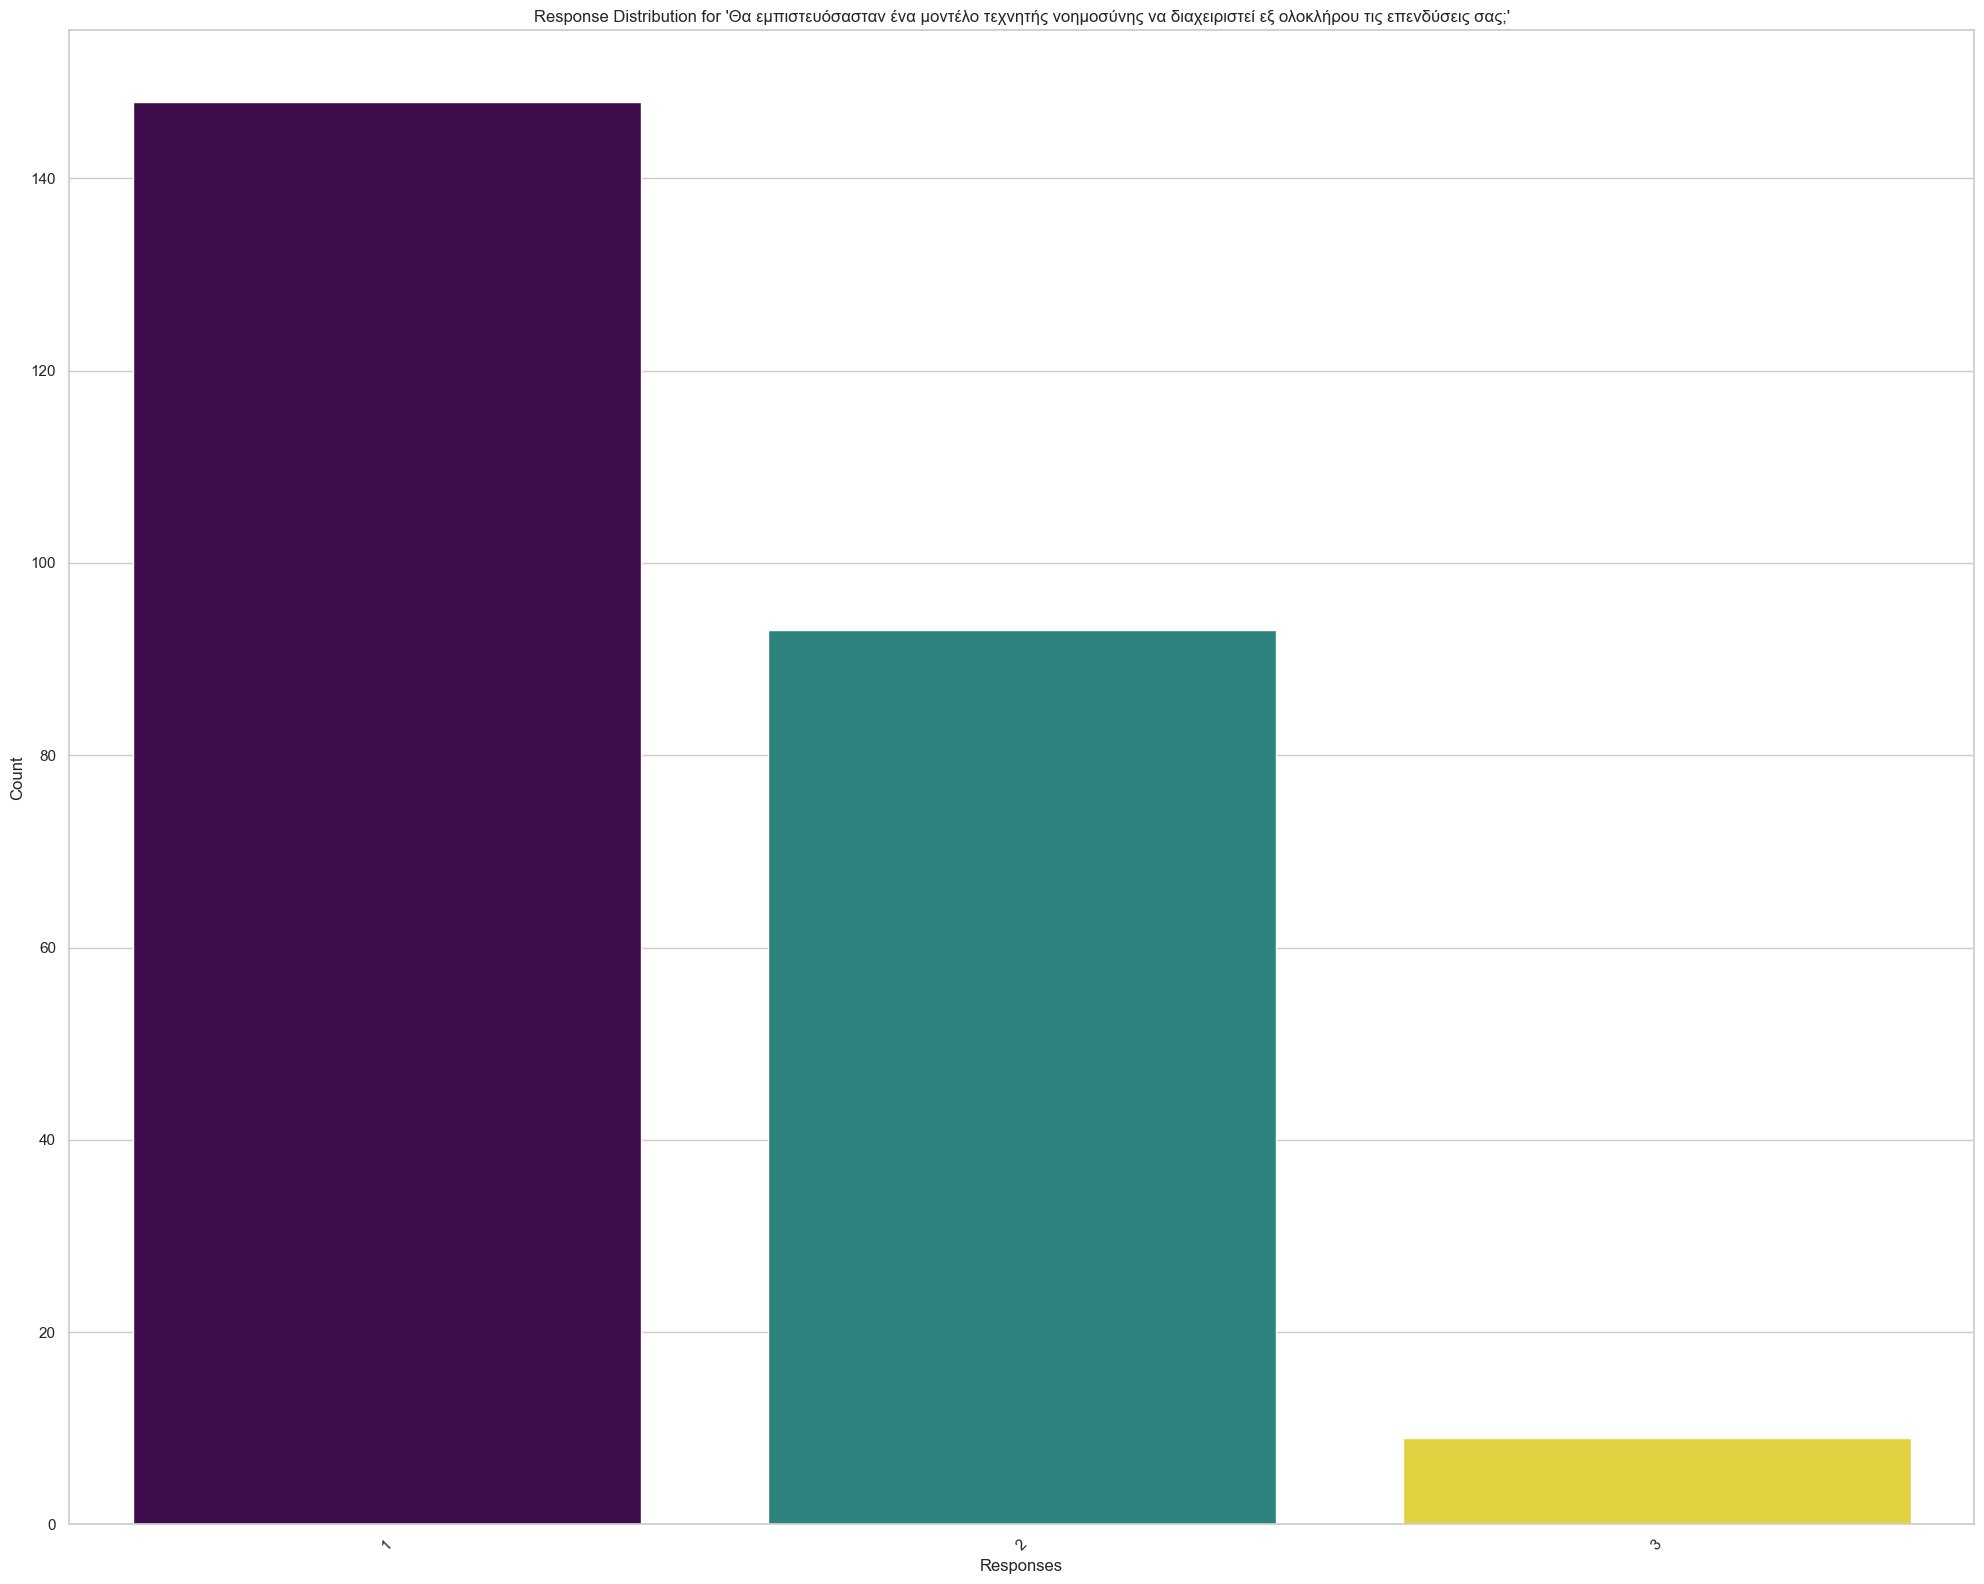

In [28]:
# 14) Data Visualization Examples (Optional)
print("### Data Visualisation ###\n")
sns.set(style="whitegrid")

# Example: Bar Plot
example_col = 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;'

if example_col in data.columns:
    plt.figure(figsize=(20, 16))
    sns.countplot(
        data=data,
        x=example_col,
        order=data[example_col].value_counts().index,
        hue=example_col,  # Use `x` as `hue` to avoid the warning
        palette="viridis",
        dodge=False  # Disable splitting of bars
    )
    plt.title(f"Response Distribution for '{example_col}'")
    plt.xlabel("Responses")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.legend([], [], frameon=False)  # Remove unnecessary legend
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{example_col}' not found for bar plot demonstration.")

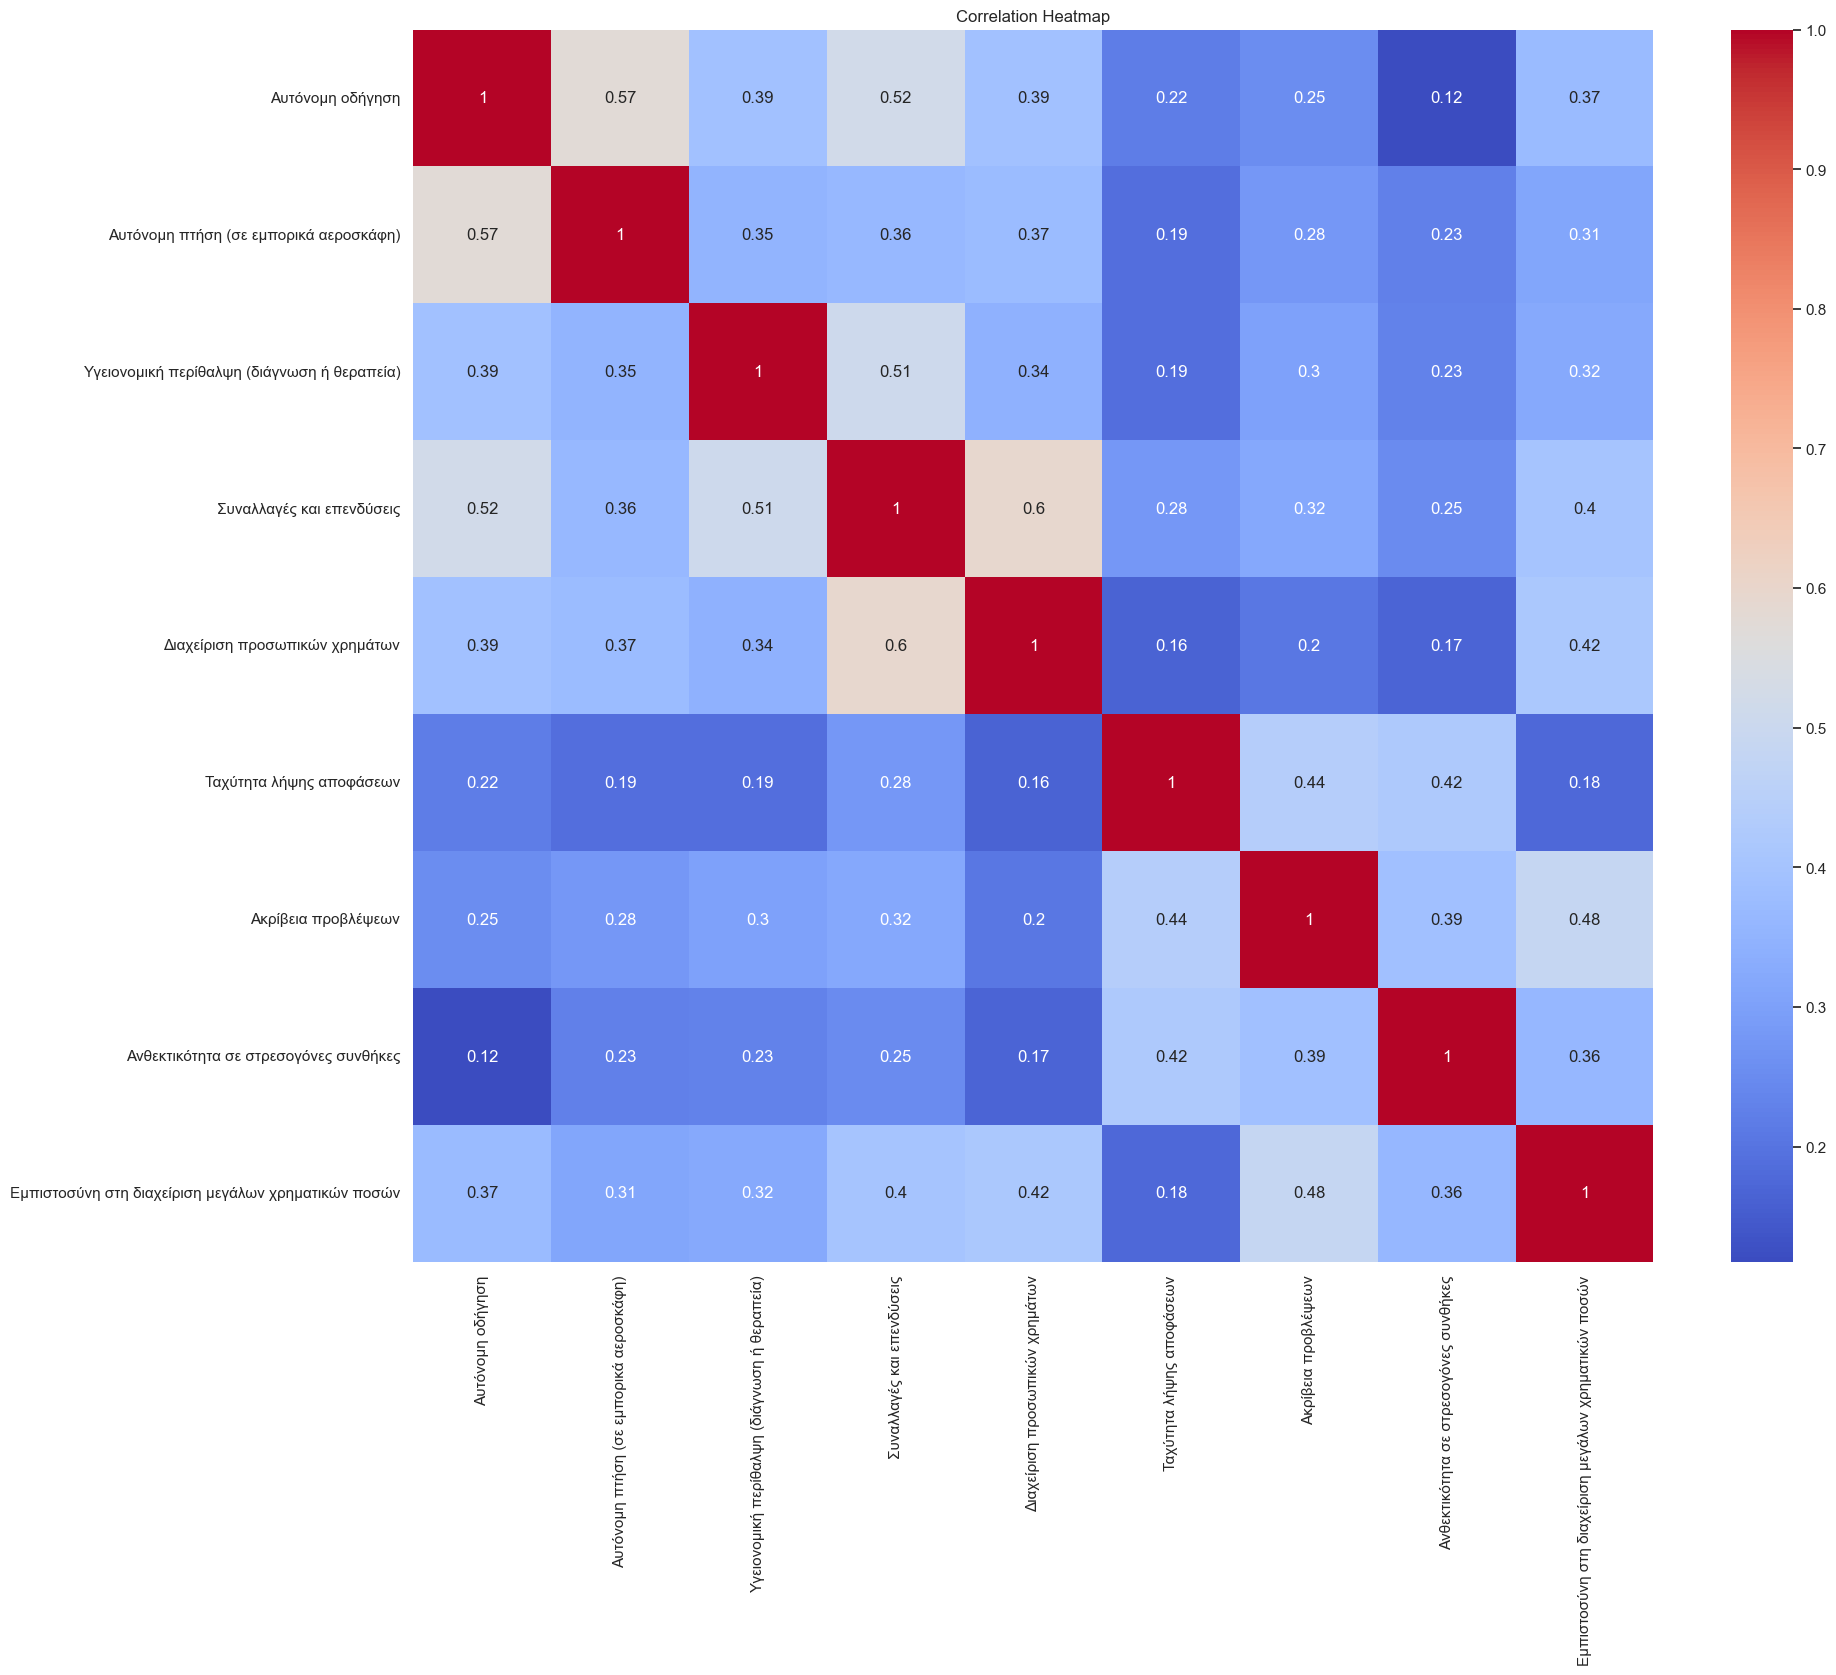

In [29]:
# Example: Correlation Heatmap
if len(numeric_cols) > 1:
    plt.figure(figsize=(20, 16))
    corr_matrix = data[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("Not enough numeric columns to generate a correlation heatmap.")

In [30]:
def perform_factor_analysis(input_data, n_factors=3):
    """
    Performs factor analysis to identify latent variables in the questionnaire input_data.
    :param input_data: The preprocessed DataFrame containing numeric columns for factor analysis.
    :param n_factors: The number of factors to extract.
    :return: The FactorAnalysis model and the factor loadings as a DataFrame.
    """
    # Standardize the numeric input_data
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(input_data)

    # Perform factor analysis
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    fa.fit(data_standardized)

    # Print factor loadings
    print("Factor Loadings:")
    loadings = pd.DataFrame(
        fa.components_.T,
        columns=[f"Factor {i+1}" for i in range(n_factors)],
        index=input_data.columns
    )
    display(loadings)

    return fa, loadings

# Example usage with your dataset
# Extract only numeric columns from the dataset
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
if len(numeric_cols) == 0:
    print("No numeric columns available for factor analysis.")
else:
    # Perform factor analysis on numeric columns
    numeric_data = data[numeric_cols]
    factor_analysis_model, factor_loadings = perform_factor_analysis(numeric_data, n_factors=3)

    # Save the factor loadings to an Excel file for further analysis (optional)
    factor_loadings.to_excel("../output/factor_loadings.xlsx", index=True)

Factor Loadings:


,Factor 1,Factor 2,Factor 3
Αυτόνομη οδήγηση,0.822439,0.365366,0.146350
Αυτόνομη πτήση (σε εμπορικά αεροσκάφη),0.626311,0.105414,0.110186
Υγειονομική περίθαλψη (διάγνωση ή θεραπεία),0.554553,-0.119411,-0.076408
Συναλλαγές και επενδύσεις,0.732236,-0.133534,-0.270192
Διαχείριση προσωπικών χρημάτων,0.621363,-0.132171,-0.442700
Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;,0.383403,-0.146246,-0.276063
Ταχύτητα λήψης αποφάσεων,0.364899,-0.352851,0.265724
Ακρίβεια προβλέψεων,0.470874,-0.481089,0.314369
Ανθεκτικότητα σε στρεσογόνες συνθήκες,0.327210,-0.471441,0.215962
Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών,0.569356,-0.302234,0.007000


In [31]:
# Filter columns related to Question 6
question_6_cols = ['Αυτόνομη οδήγηση', 'Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)',
                   'Υγειονομική περίθαλψη (διάγνωση ή θεραπεία)',
                   'Συναλλαγές και επενδύσεις', 'Διαχείριση προσωπικών χρημάτων']

# Perform Factor Analysis on Question 6 columns
factor_analysis_model_6, factor_loadings_6 = perform_factor_analysis(data[question_6_cols], n_factors=2)

Factor Loadings:


,Factor 1,Factor 2
Αυτόνομη οδήγηση,0.649975,0.310312
Αυτόνομη πτήση (σε εμπορικά αεροσκάφη),0.572040,0.648529
Υγειονομική περίθαλψη (διάγνωση ή θεραπεία),0.569421,0.041487
Συναλλαγές και επενδύσεις,0.910570,-0.239419
Διαχείριση προσωπικών χρημάτων,0.647844,-0.010531


In [32]:
# Filter columns related to Question 20
question_20_cols = ['Ταχύτητα λήψης αποφάσεων', 'Ακρίβεια προβλέψεων',
                    'Ανθεκτικότητα σε στρεσογόνες συνθήκες',
                    'Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών']

# Perform Factor Analysis on Question 20 columns
factor_analysis_model_20, factor_loadings_20 = perform_factor_analysis(data[question_20_cols], n_factors=2)

Factor Loadings:


,Factor 1,Factor 2
Ταχύτητα λήψης αποφάσεων,-0.674854,-0.501931
Ακρίβεια προβλέψεων,-0.692754,0.060599
Ανθεκτικότητα σε στρεσογόνες συνθήκες,-0.584560,-0.044828
Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών,-0.650661,0.521824


In [33]:
def perform_cluster_analysis(input_data, numeric_cols, n_clusters=3):
    """
    Performs K-means clustering to group respondents based on their responses.

    Parameters:
    - input_data: The original dataframe.
    - numeric_cols: List of columns to use for clustering (numeric responses).
    - n_clusters: Number of clusters to form.

    Returns:
    - data_with_clusters: DataFrame with cluster assignments added.
    """
    # Filter the numeric columns for clustering
    data_numeric = input_data[numeric_cols].dropna()  # Remove rows with NaNs in numeric columns

    # Standardize the input_data
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_numeric)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(data_standardized)

    # Add cluster labels to the original input_data
    data_with_clusters = input_data.copy()
    data_with_clusters.loc[data_numeric.index, 'Cluster'] = clusters

    # Print cluster sizes
    print("Cluster Sizes:")
    print(data_with_clusters['Cluster'].value_counts())

    # Print cluster centers
    cluster_centers = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=numeric_cols,
        index=[f"Cluster {i}" for i in range(n_clusters)]
    )
    print("\nCluster Centers (Standardized):")
    display(cluster_centers)

    return data_with_clusters, cluster_centers

# Example usage
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]

# Perform clustering
clustered_data, cluster_centers = perform_cluster_analysis(data, numeric_cols, n_clusters=3)

# Example: Analyze the characteristics of each cluster
for cluster_id in range(3):
    print(f"\nCluster {cluster_id} Characteristics:")
    cluster_data = clustered_data[clustered_data['Cluster'] == cluster_id]
    print(cluster_data.describe())  # Summary statistics for the cluster

Cluster Sizes:
Cluster
2.0    111
0.0    105
1.0     34
Name: count, dtype: int64

Cluster Centers (Standardized):


,Αυτόνομη οδήγηση,Αυτόνομη πτήση (σε εμπορικά αεροσκάφη),Υγειονομική περίθαλψη (διάγνωση ή θεραπεία),Συναλλαγές και επενδύσεις,Διαχείριση προσωπικών χρημάτων,Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;,Ταχύτητα λήψης αποφάσεων,Ακρίβεια προβλέψεων,Ανθεκτικότητα σε στρεσογόνες συνθήκες,Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών
Cluster 0,-0.418720,-0.407578,-0.349773,-0.480591,-0.482117,-0.280310,0.375470,0.026270,0.259012,-0.245835
Cluster 1,-0.821557,-0.925522,-0.728443,-0.860835,-0.644473,-0.473771,-1.670669,-1.237252,-1.358572,-1.083423
Cluster 2,0.647735,0.669040,0.553993,0.718292,0.653463,0.410277,0.156562,0.354128,0.171128,0.564406



Cluster 0 Characteristics:
       Αυτόνομη οδήγηση  Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)  \
count        105.000000                              105.000000   
mean           2.000000                                1.980952   
std            0.919866                                0.970537   
min            1.000000                                1.000000   
25%            1.000000                                1.000000   
50%            2.000000                                2.000000   
75%            3.000000                                3.000000   
max            5.000000                                5.000000   

       Υγειονομική περίθαλψη (διάγνωση ή θεραπεία)  Συναλλαγές και επενδύσεις  \
count                                   105.000000                 105.000000   
mean                                      2.380952                   2.390476   
std                                       1.059580                   0.849154   
min                                       1.

Explained Variance Ratio:
[0.38691222 0.13644253 0.09691432]

Cumulative Explained Variance:
[0.38691222 0.52335476 0.62026908]


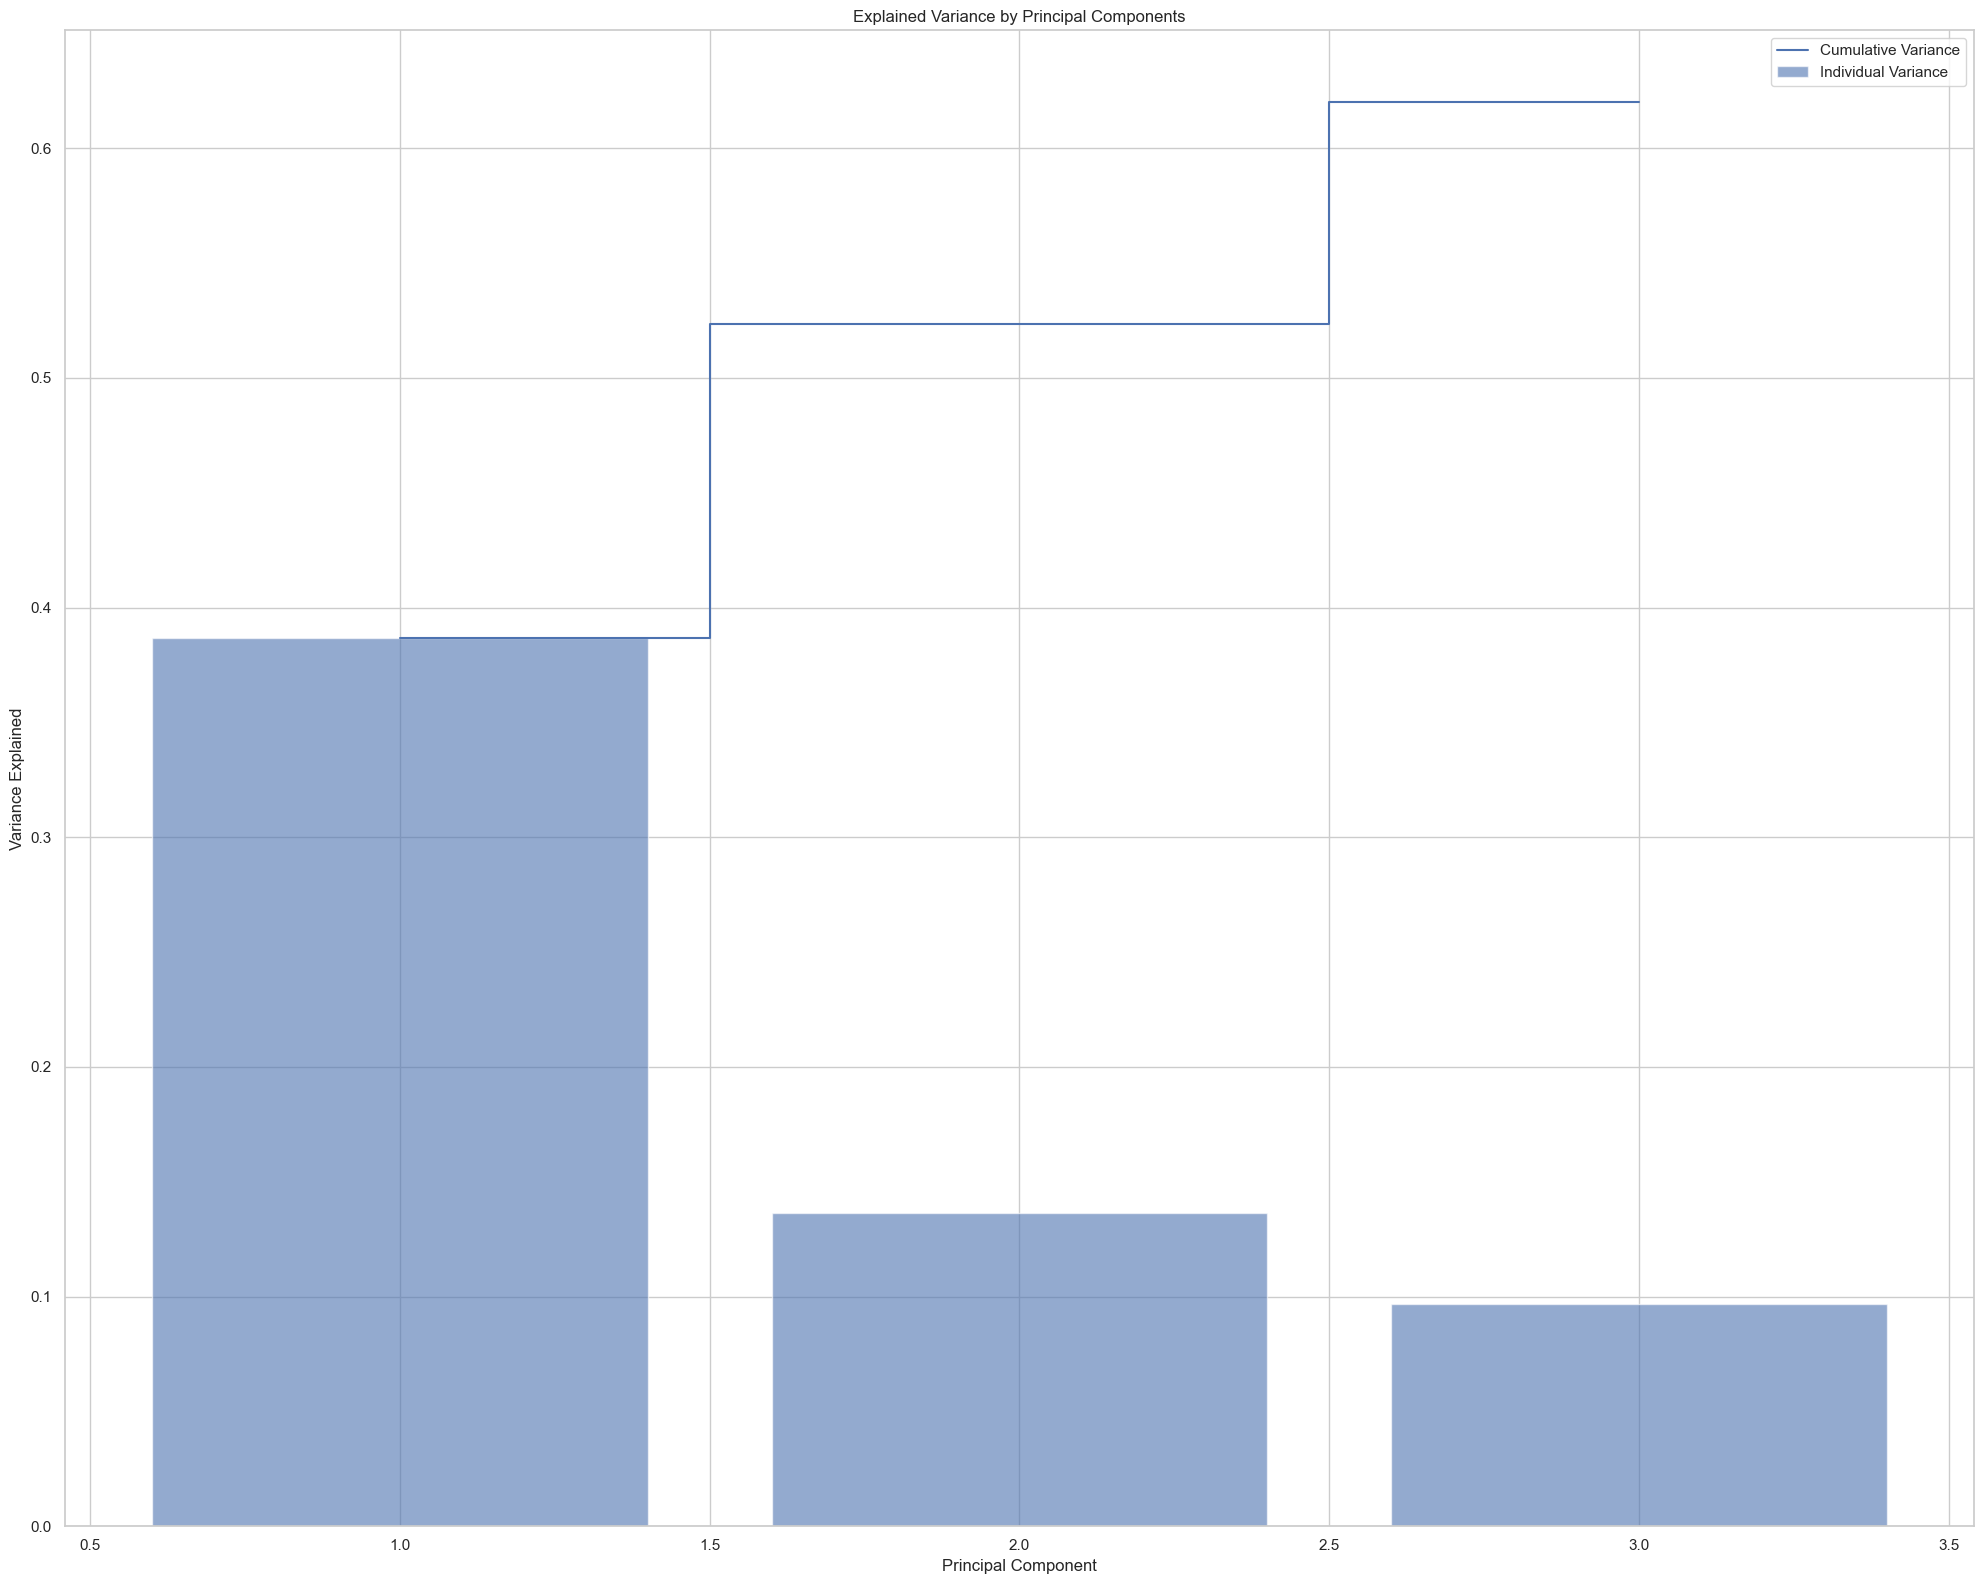

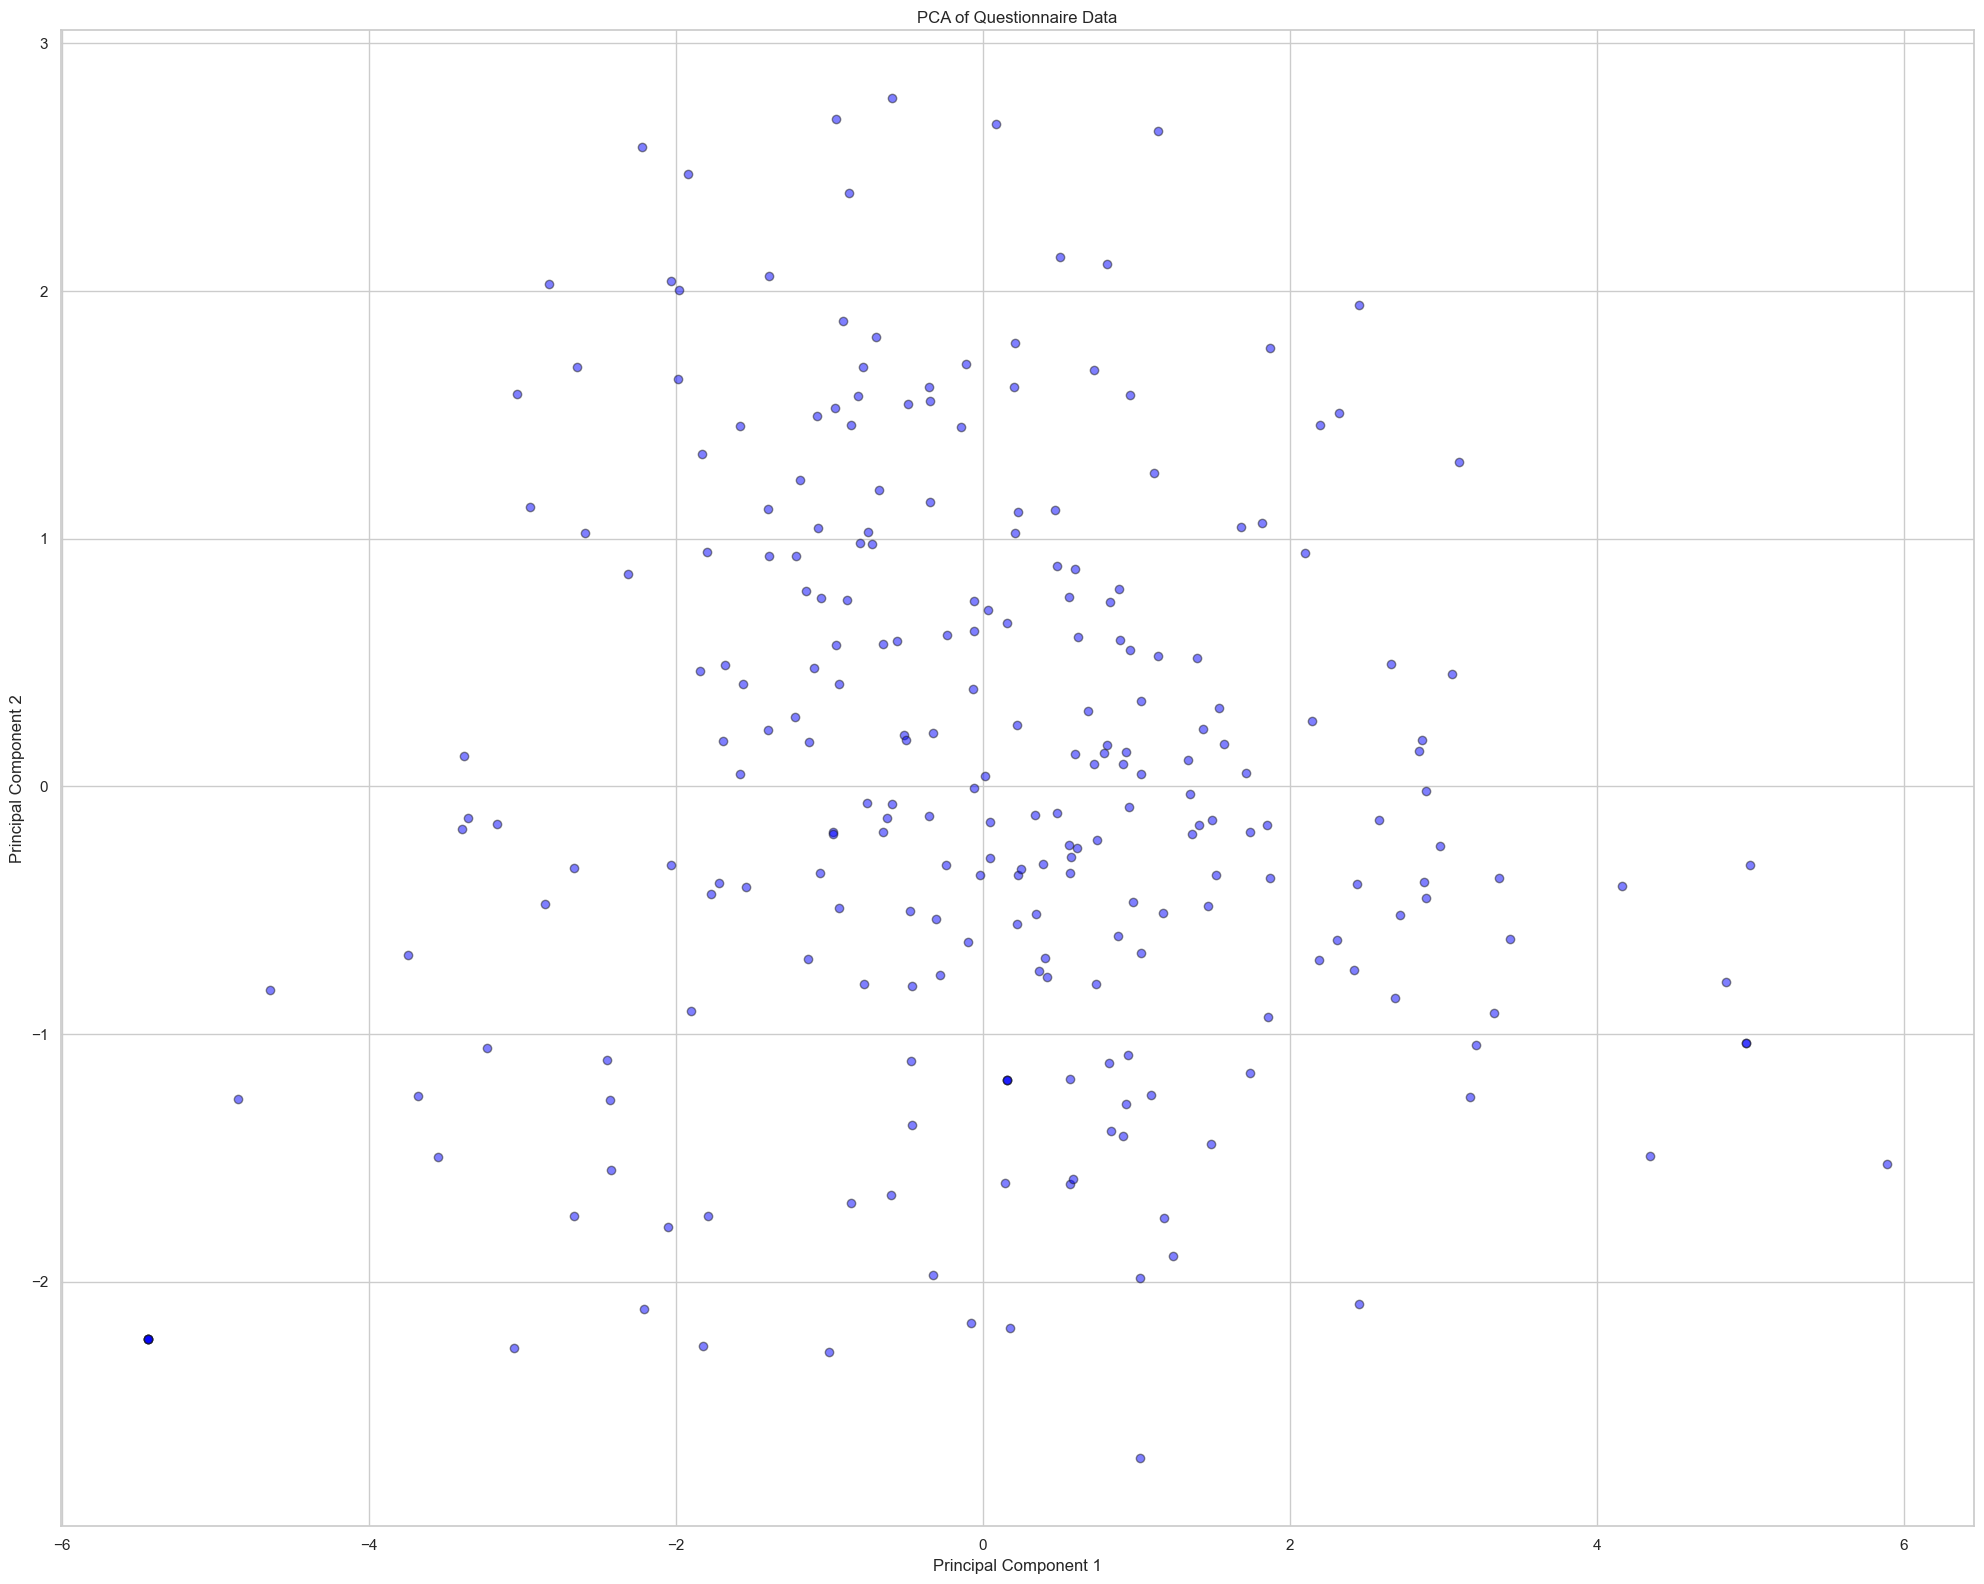


PCA Loadings (Variable Contributions to PCs):


,PC1,PC2,PC3
Αυτόνομη οδήγηση,0.347225,-0.257416,-0.420835
Αυτόνομη πτήση (σε εμπορικά αεροσκάφη),0.321906,-0.147229,-0.527649
Υγειονομική περίθαλψη (διάγνωση ή θεραπεία),0.325969,-0.118832,-0.111722
Συναλλαγές και επενδύσεις,0.392896,-0.197480,0.081822
Διαχείριση προσωπικών χρημάτων,0.343288,-0.303281,0.220115
Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;,0.244672,-0.225485,0.649039
Ταχύτητα λήψης αποφάσεων,0.244248,0.497608,-0.032022
Ακρίβεια προβλέψεων,0.307805,0.431527,0.007943
Ανθεκτικότητα σε στρεσογόνες συνθήκες,0.249380,0.525632,0.047112
Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών,0.347688,0.077468,0.228686


In [34]:
def perform_pca(input_data, numeric_cols, n_components=2):
    """
    Performs PCA to reduce the dimensionality of the questionnaire input_data.

    Parameters:
    - input_data: DataFrame containing the questionnaire responses.
    - numeric_cols: List of numeric columns to include in the PCA.
    - n_components: Number of principal components to extract.

    Returns:
    - pca_results: Transformed input_data in the new principal component space.
    - pca: Fitted PCA model.
    """
    # Filter numeric columns and remove rows with missing values
    data_numeric = input_data[numeric_cols].dropna()

    # Standardize the input_data
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_numeric)

    # Perform PCA
    pca = PCA(n_components=n_components, random_state=42)
    pca_results = pca.fit_transform(data_standardized)

    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)

    # Cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    print("\nCumulative Explained Variance:")
    print(cumulative_variance)

    # Visualize explained variance
    plt.figure(figsize=(20, 16))
    plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.6, label='Individual Variance')
    plt.step(range(1, n_components + 1), cumulative_variance, where='mid', label='Cumulative Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.title('Explained Variance by Principal Components')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatter plot of the first two principal components
    if n_components >= 2:
        plt.figure(figsize=(20, 16))
        plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, c='blue', edgecolor='k')
        plt.title("PCA of Questionnaire Data")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Loadings: Contribution of each variable to the principal components
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f"PC{i+1}" for i in range(n_components)],
        index=numeric_cols
    )
    print("\nPCA Loadings (Variable Contributions to PCs):")
    display(loadings)

    return pca_results, pca, loadings

# Example usage
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]

# Perform PCA
pca_results, pca_model, pca_loadings = perform_pca(data, numeric_cols, n_components=3)

PCA for Question 6:
Explained Variance Ratio:
[0.55541937 0.15693315]

Cumulative Explained Variance:
[0.55541937 0.71235252]


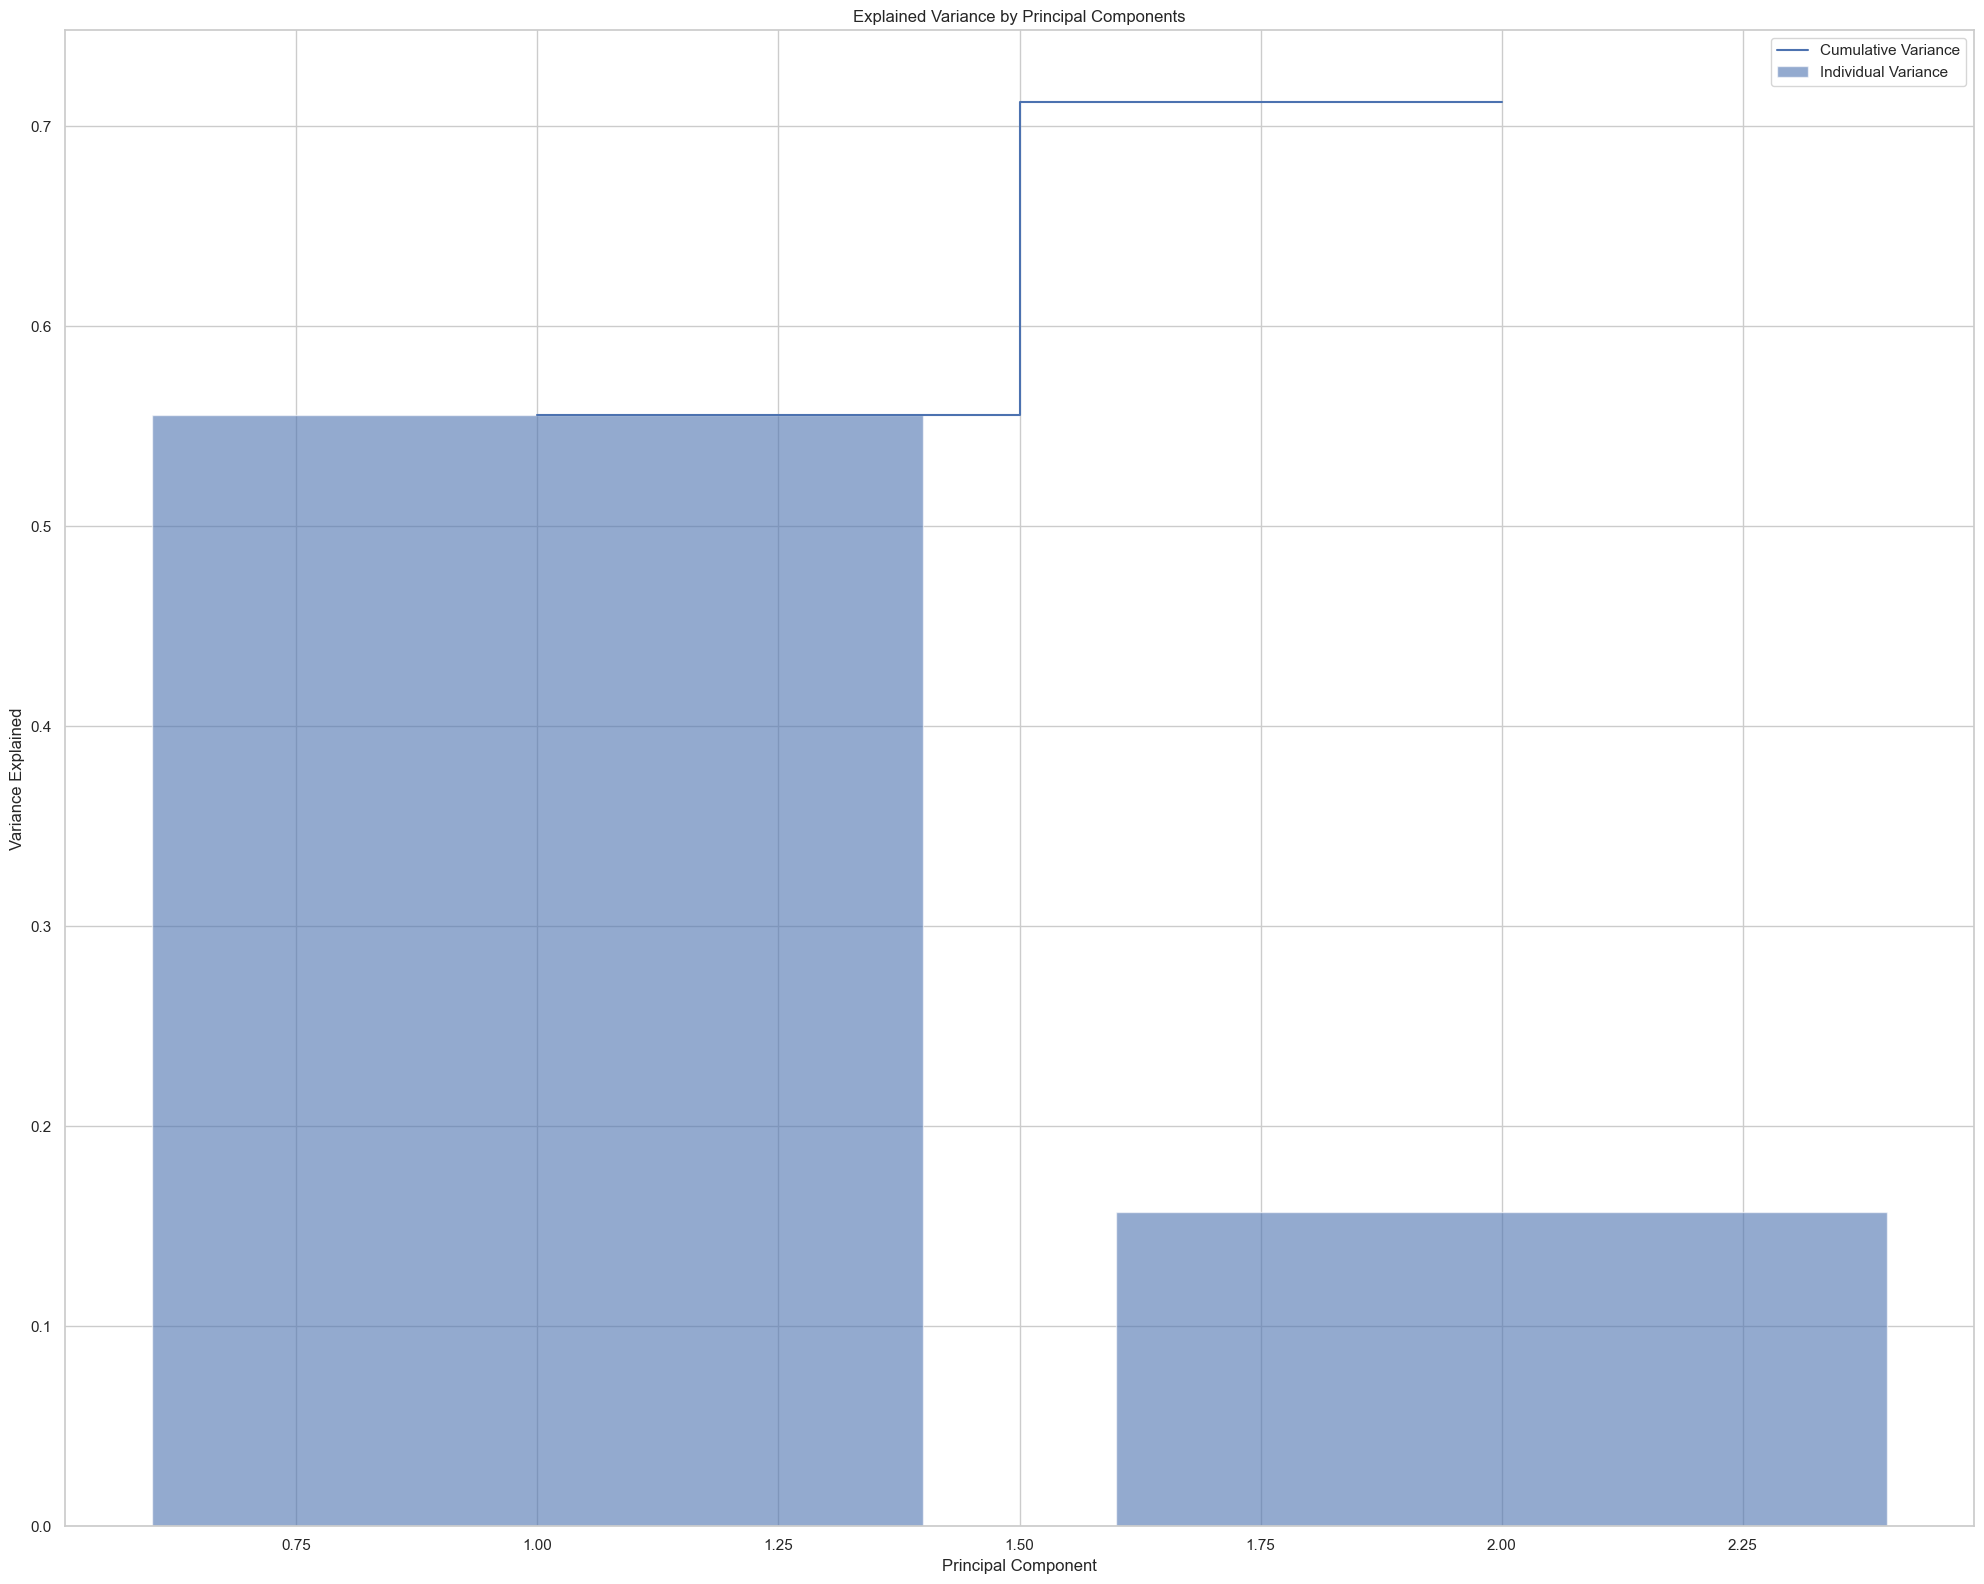

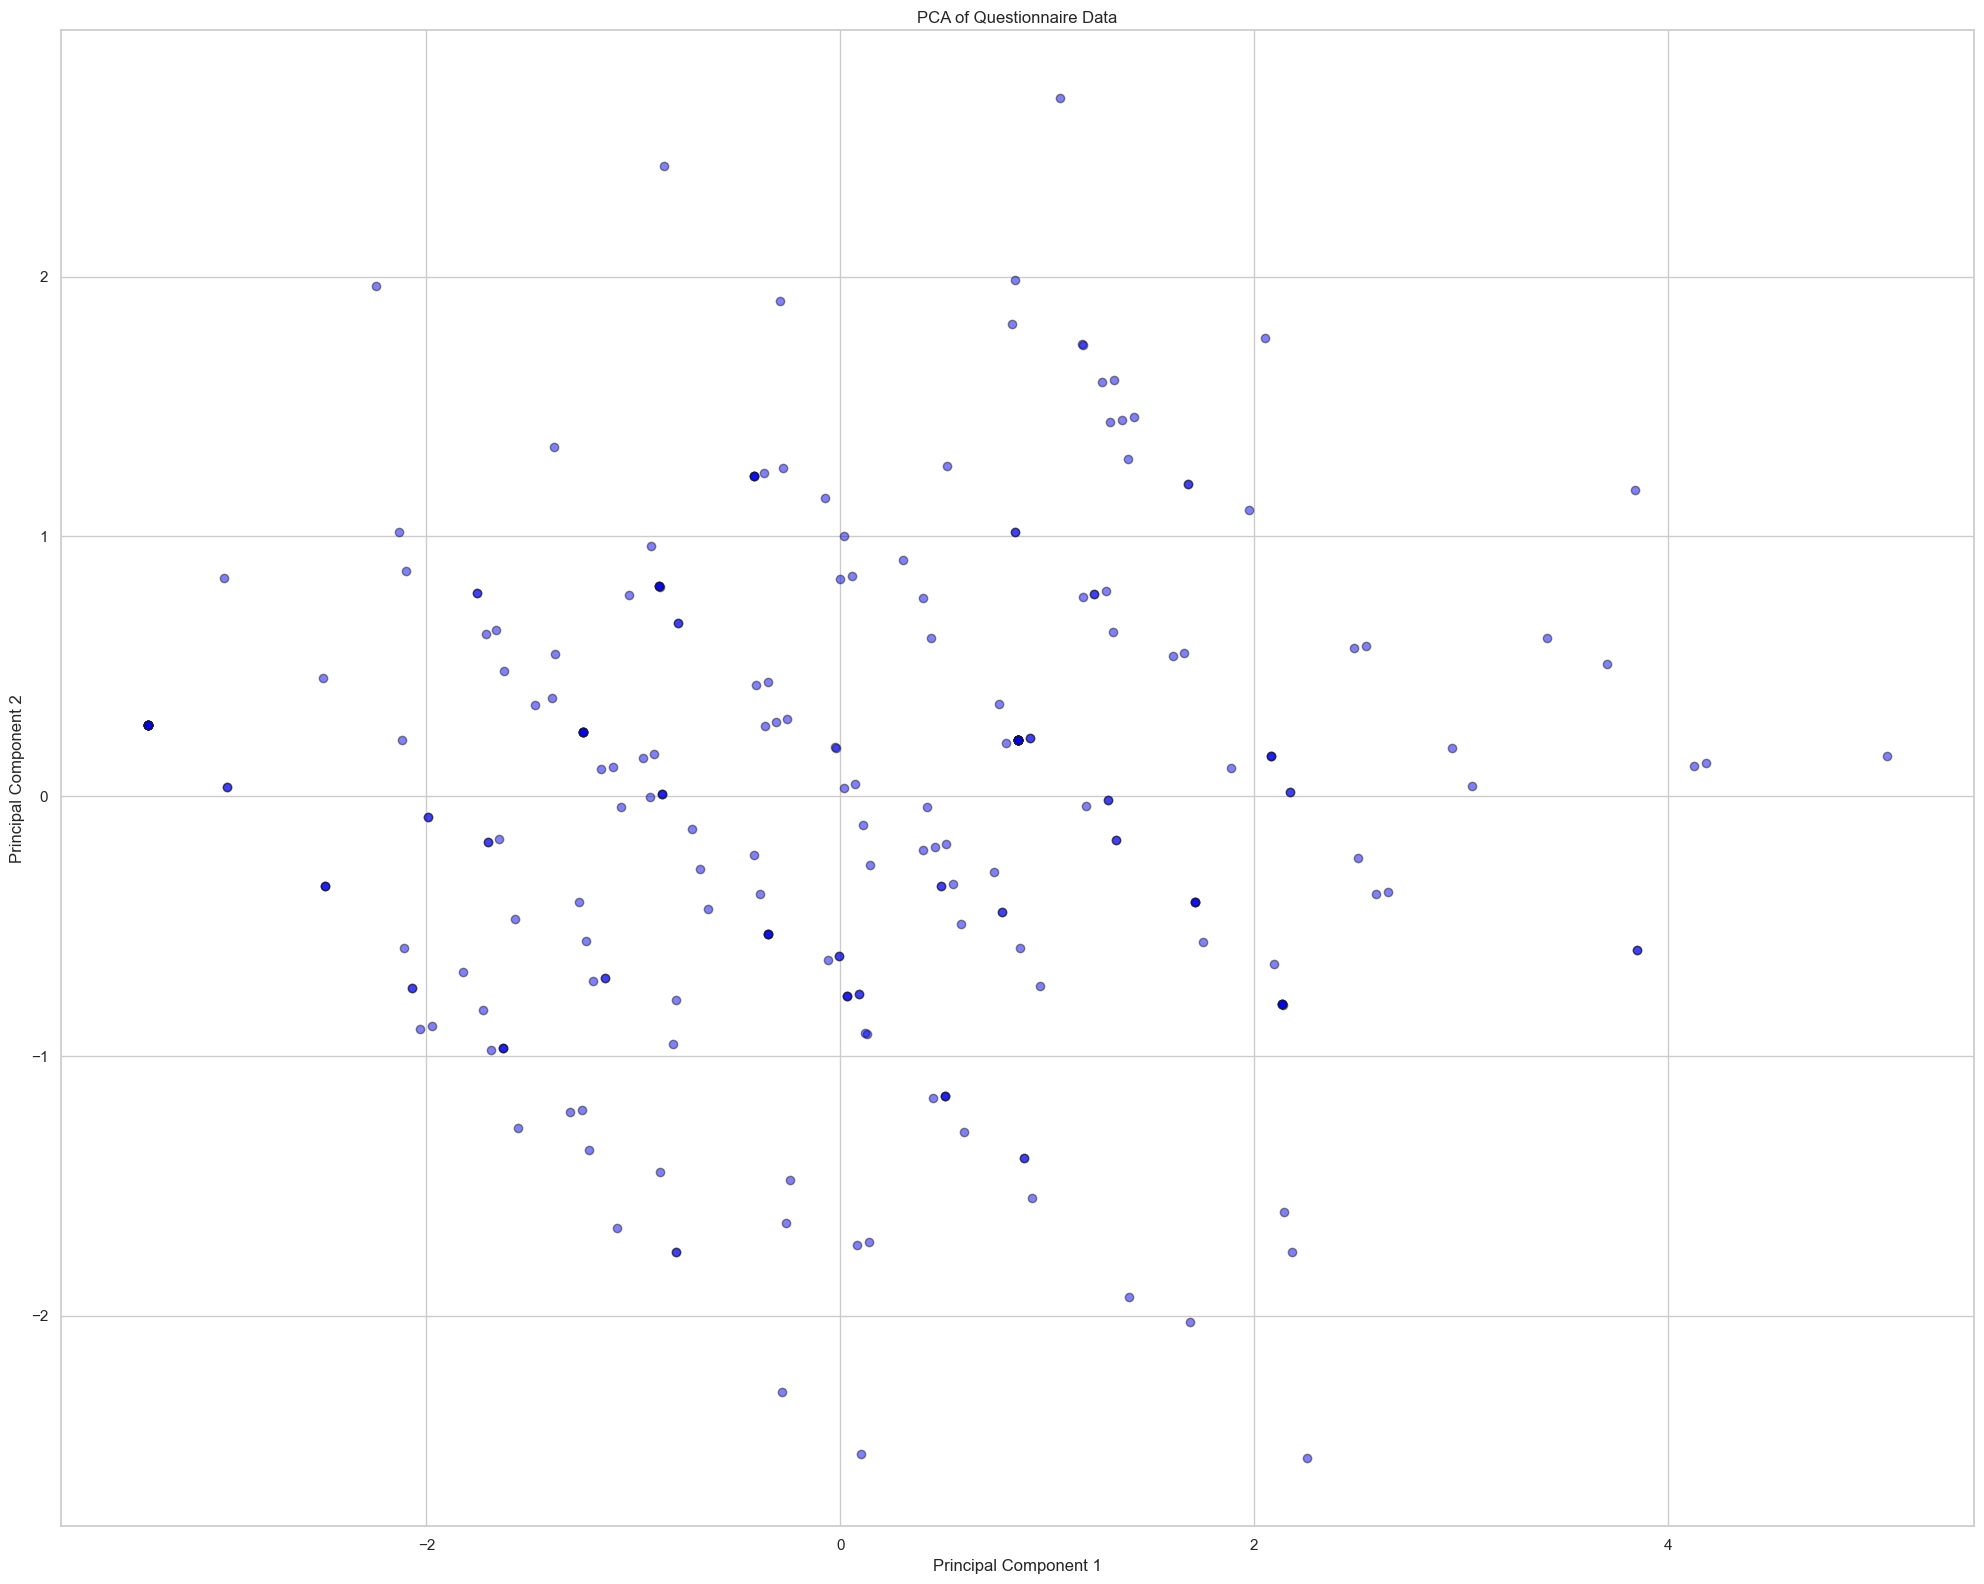


PCA Loadings (Variable Contributions to PCs):


,PC1,PC2
Αυτόνομη οδήγηση,0.467801,0.431544
Αυτόνομη πτήση (σε εμπορικά αεροσκάφη),0.425177,0.650736
Υγειονομική περίθαλψη (διάγνωση ή θεραπεία),0.412706,-0.258317
Συναλλαγές και επενδύσεις,0.489173,-0.394041
Διαχείριση προσωπικών χρημάτων,0.436772,-0.410264


In [35]:
# Perform PCA for Question 6
print("PCA for Question 6:")
pca_results_6, pca_model_6, pca_loadings_6 = perform_pca(data, question_6_cols, n_components=2)


PCA for Question 20:
Explained Variance Ratio:
[0.53581614 0.20933308]

Cumulative Explained Variance:
[0.53581614 0.74514922]


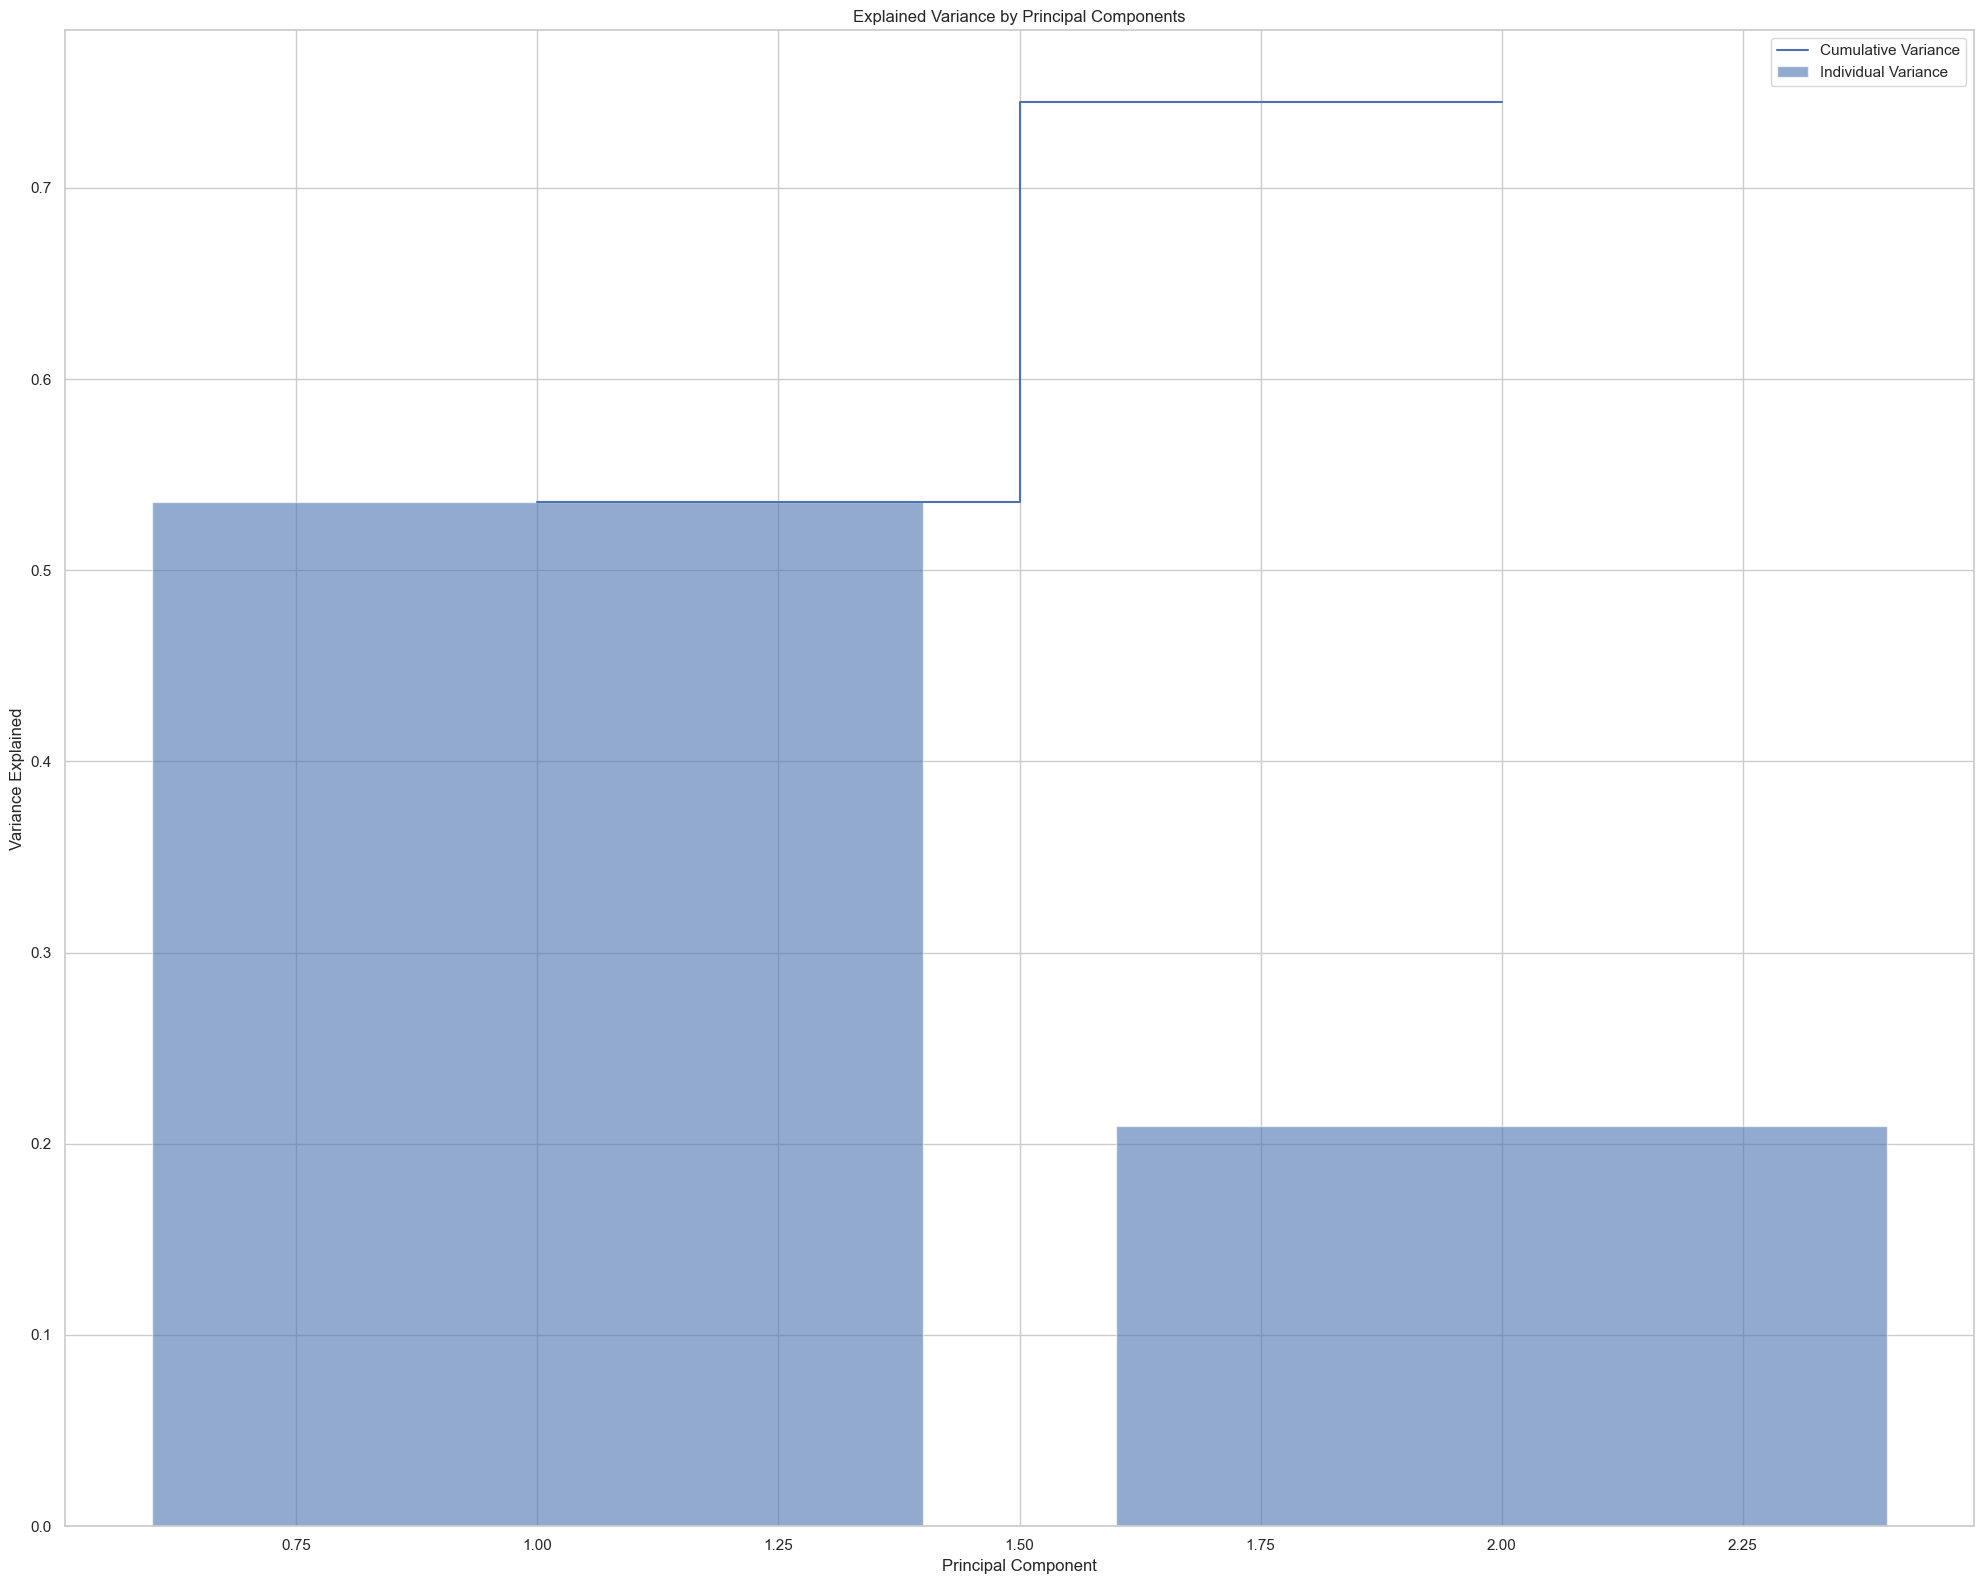

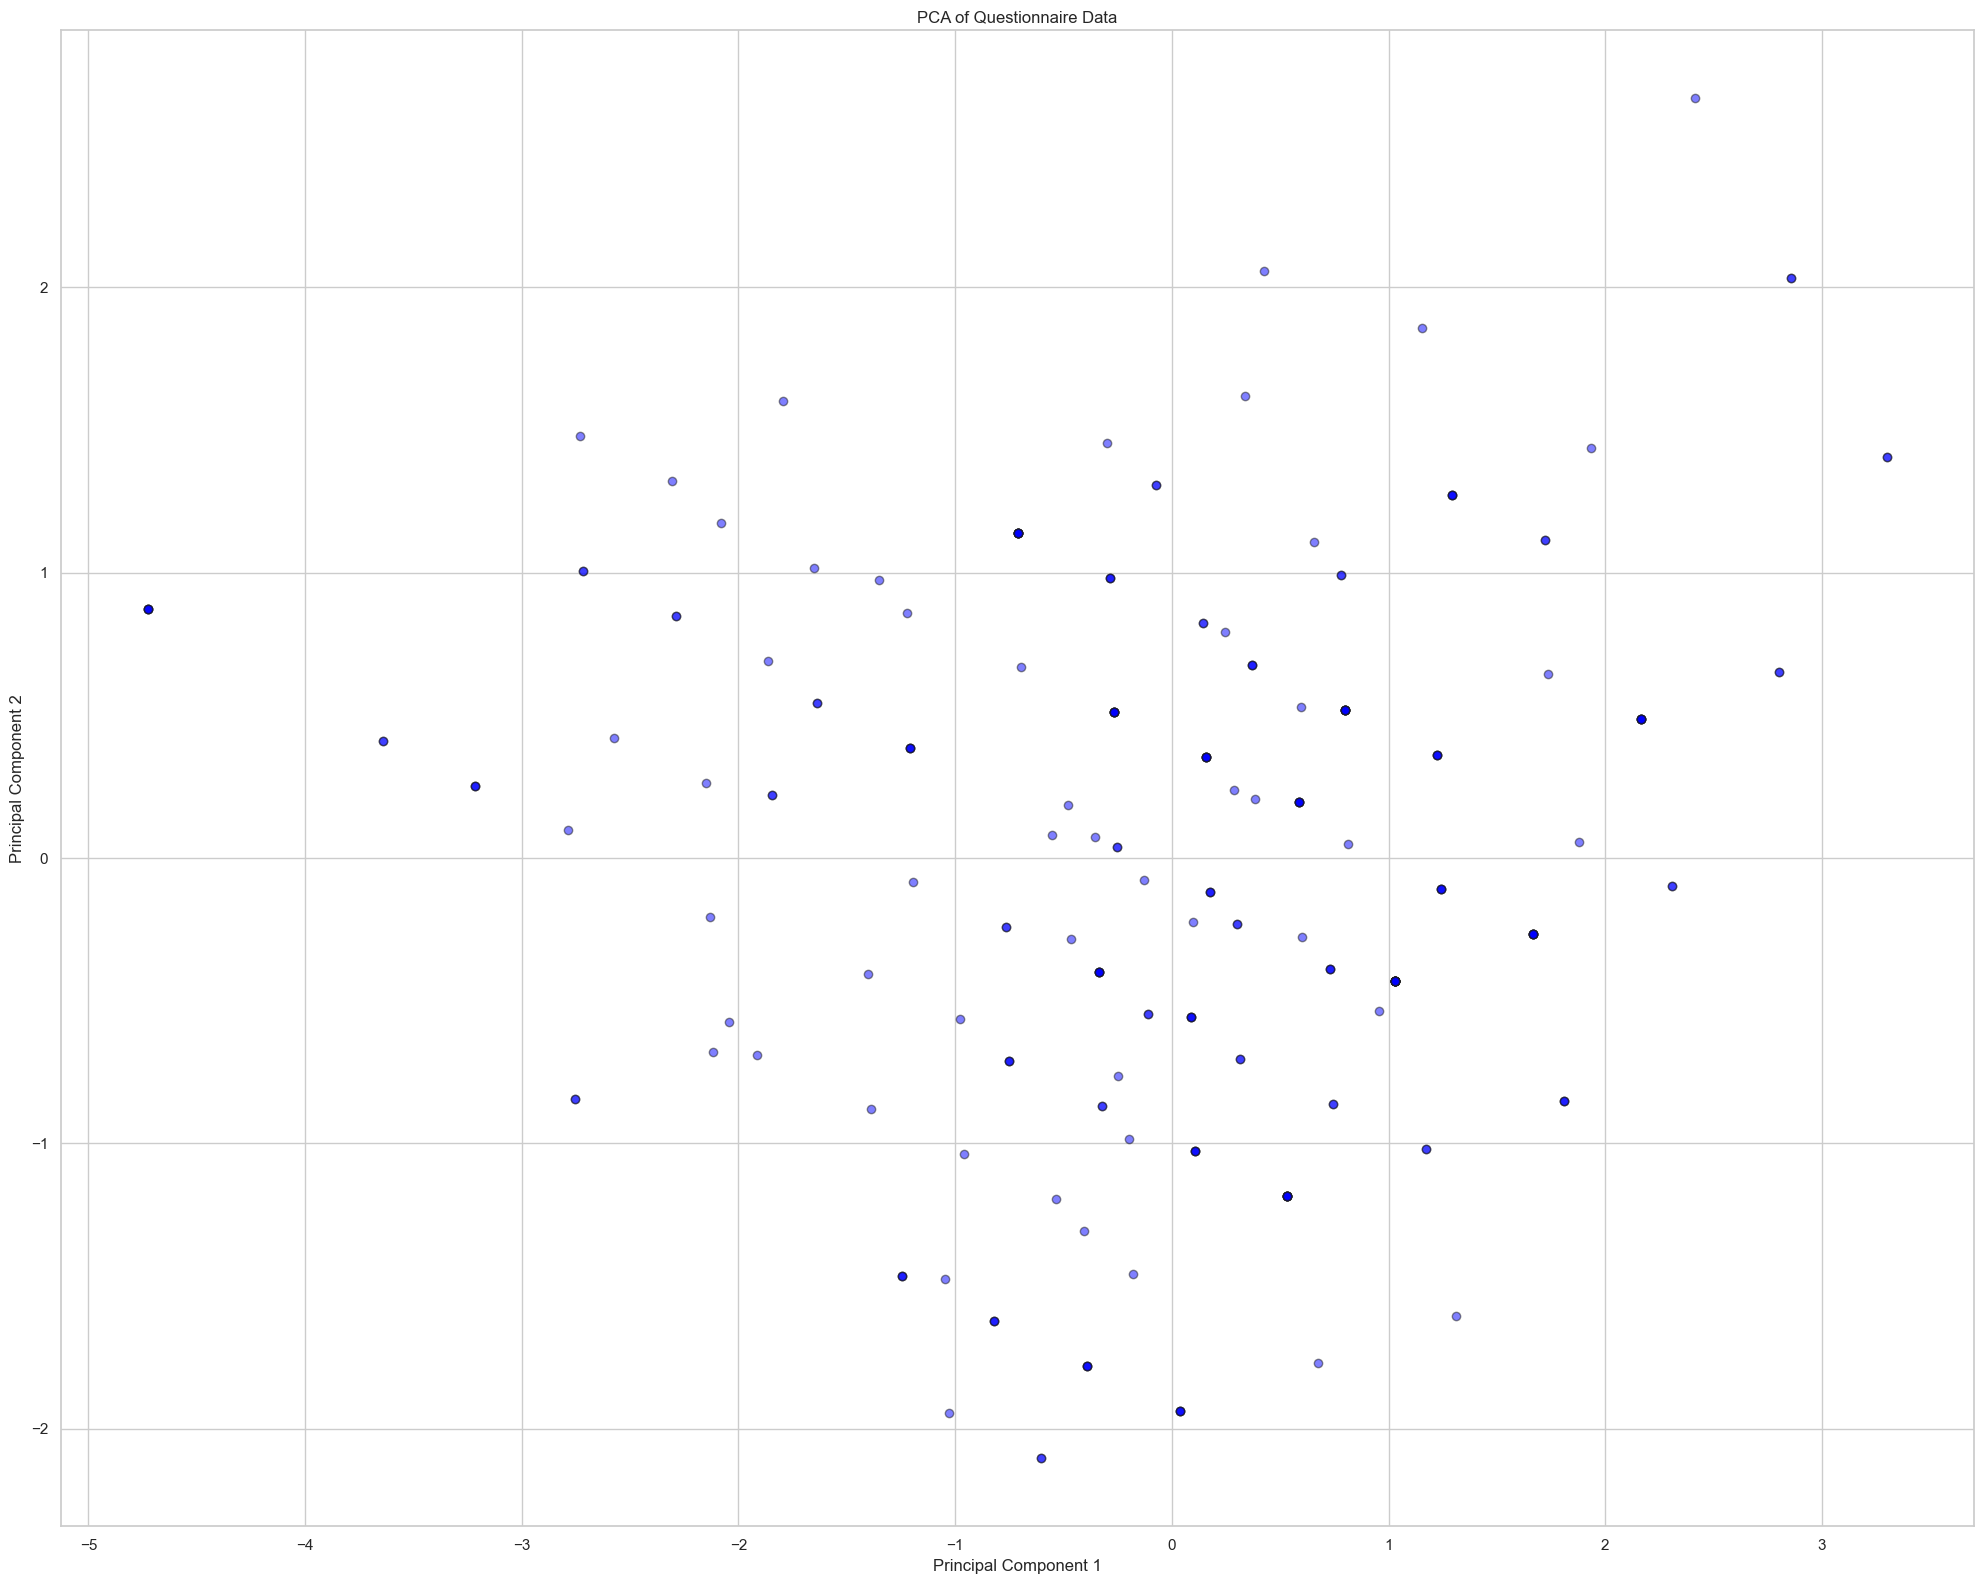


PCA Loadings (Variable Contributions to PCs):


,PC1,PC2
Ταχύτητα λήψης αποφάσεων,0.470610,-0.667420
Ακρίβεια προβλέψεων,0.550778,0.143551
Ανθεκτικότητα σε στρεσογόνες συνθήκες,0.507438,-0.186439
Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών ποσών,0.466558,0.706529


In [36]:
# Perform PCA for Question 20
print("\nPCA for Question 20:")
pca_results_20, pca_model_20, pca_loadings_20 = perform_pca(data, question_20_cols, n_components=2)


Analyzing sentiment for: Τι πιστεύετε ότι είναι το μεγαλύτερο πλεονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;
Translating 'Τι πιστεύετε ότι είναι το μεγαλύτερο πλεονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;' to English...
Sentiment Analysis Results for 'Τι πιστεύετε ότι είναι το μεγαλύτερο πλεονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;':
count    250.000000
mean       0.085000
std        0.179314
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: Τι πιστεύετε ότι είναι το μεγαλύτερο πλεονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;, dtype: float64


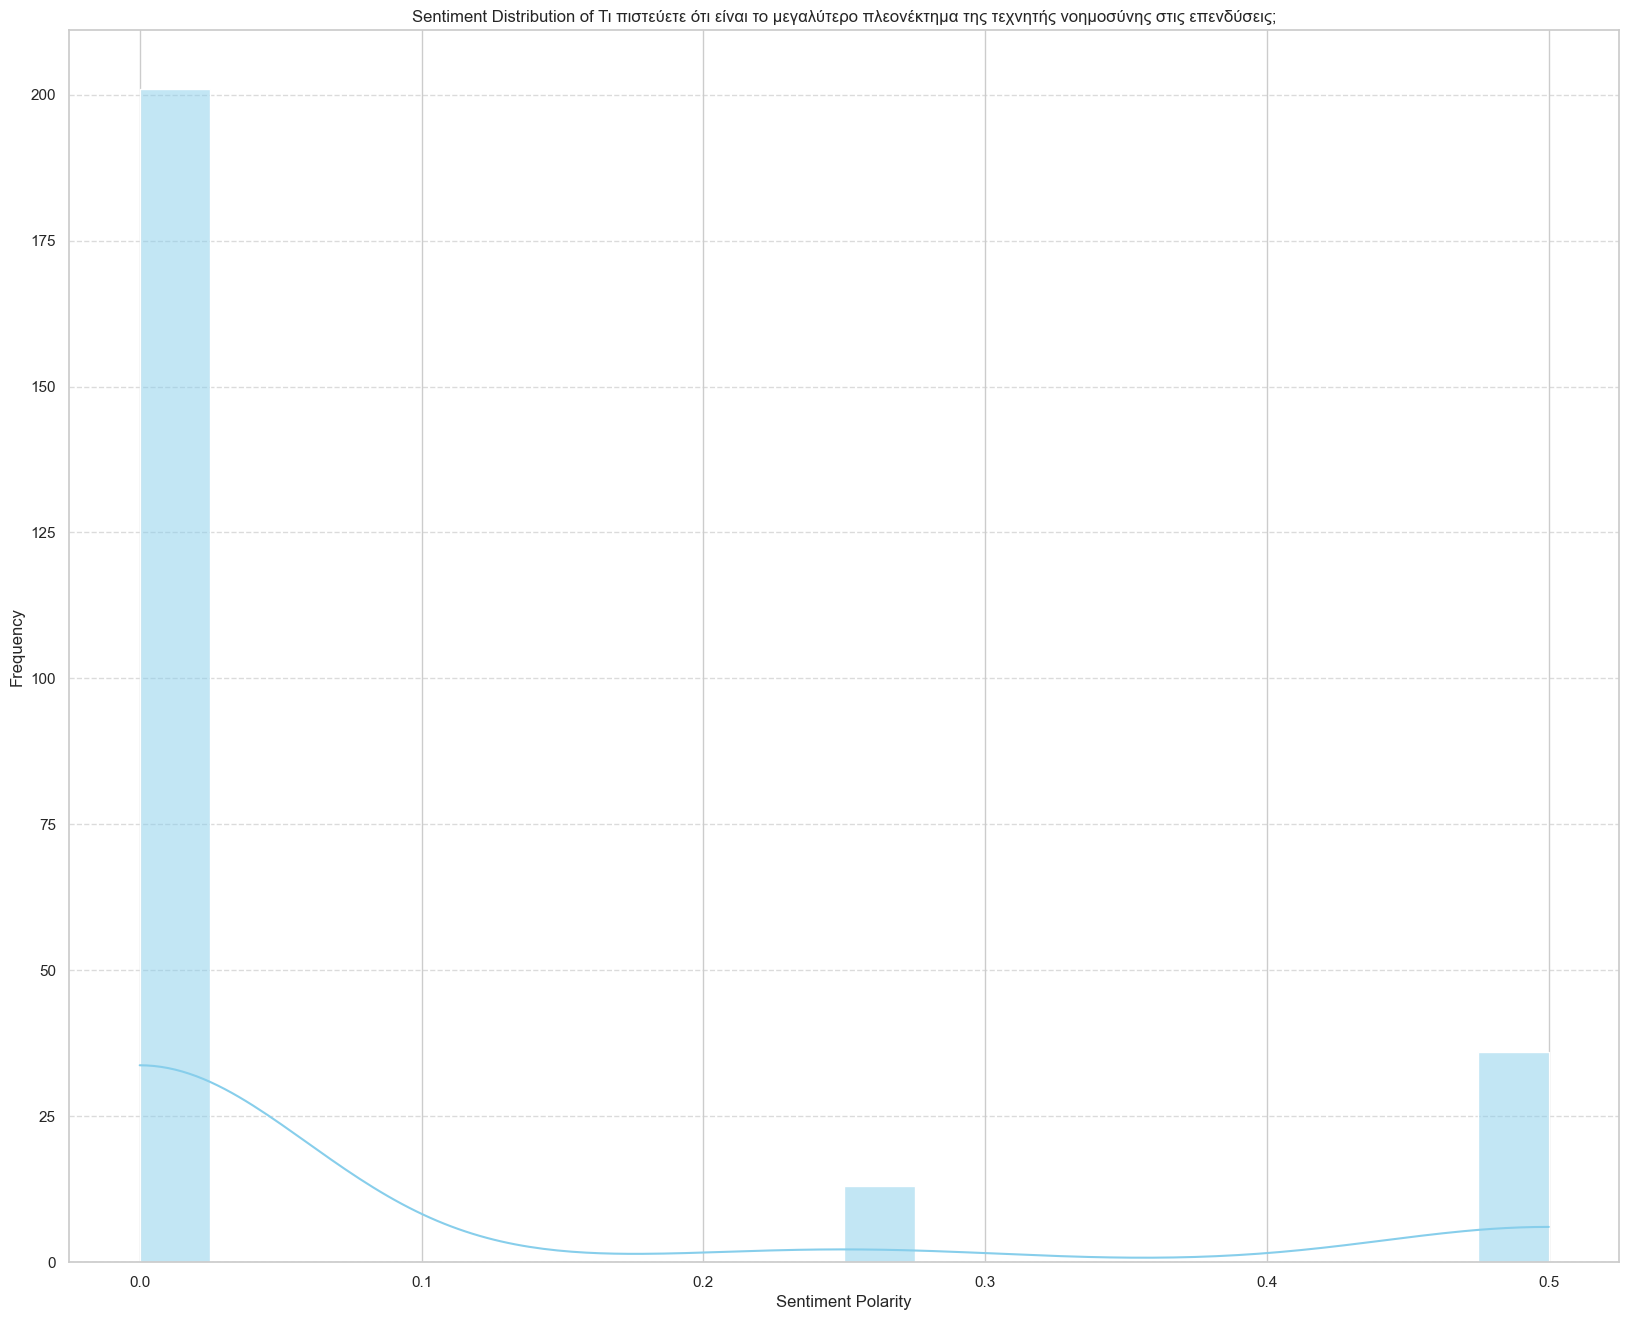


Analyzing sentiment for: Ποιο θεωρείτε το μεγαλύτερο μειονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;
Translating 'Ποιο θεωρείτε το μεγαλύτερο μειονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;' to English...
Sentiment Analysis Results for 'Ποιο θεωρείτε το μεγαλύτερο μειονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;':
count    250.000000
mean      -0.006947
std        0.107061
min       -0.500000
25%       -0.075000
50%        0.000000
75%        0.050000
max        0.563333
Name: Ποιο θεωρείτε το μεγαλύτερο μειονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;, dtype: float64


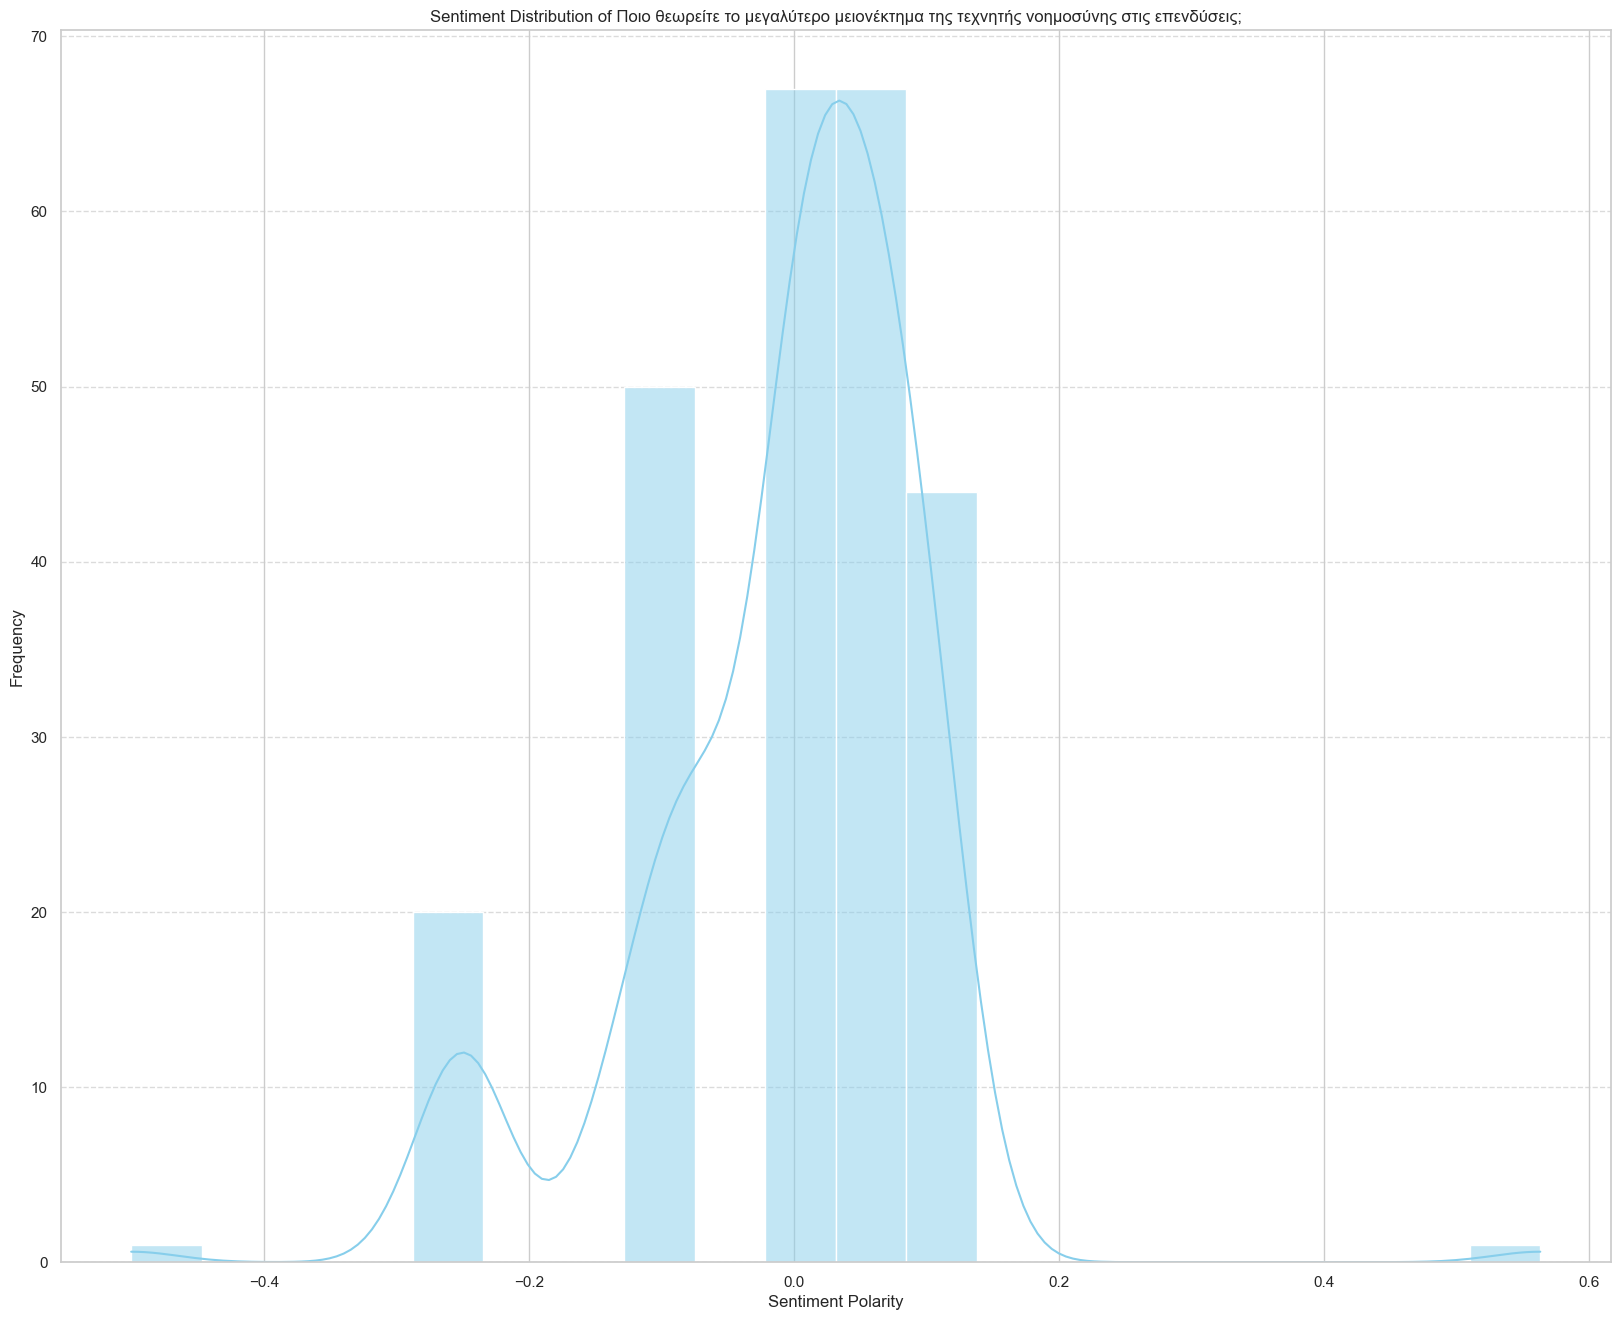


Analyzing sentiment for: Τι σας ανησυχεί περισσότερο σχετικά με τη χρήση της τεχνητής νοημοσύνης στις επενδύσεις;
Translating 'Τι σας ανησυχεί περισσότερο σχετικά με τη χρήση της τεχνητής νοημοσύνης στις επενδύσεις;' to English...
Sentiment Analysis Results for 'Τι σας ανησυχεί περισσότερο σχετικά με τη χρήση της τεχνητής νοημοσύνης στις επενδύσεις;':
count    250.000000
mean      -0.091267
std        0.130303
min       -0.308333
25%       -0.300000
50%        0.000000
75%        0.000000
max        0.000000
Name: Τι σας ανησυχεί περισσότερο σχετικά με τη χρήση της τεχνητής νοημοσύνης στις επενδύσεις;, dtype: float64


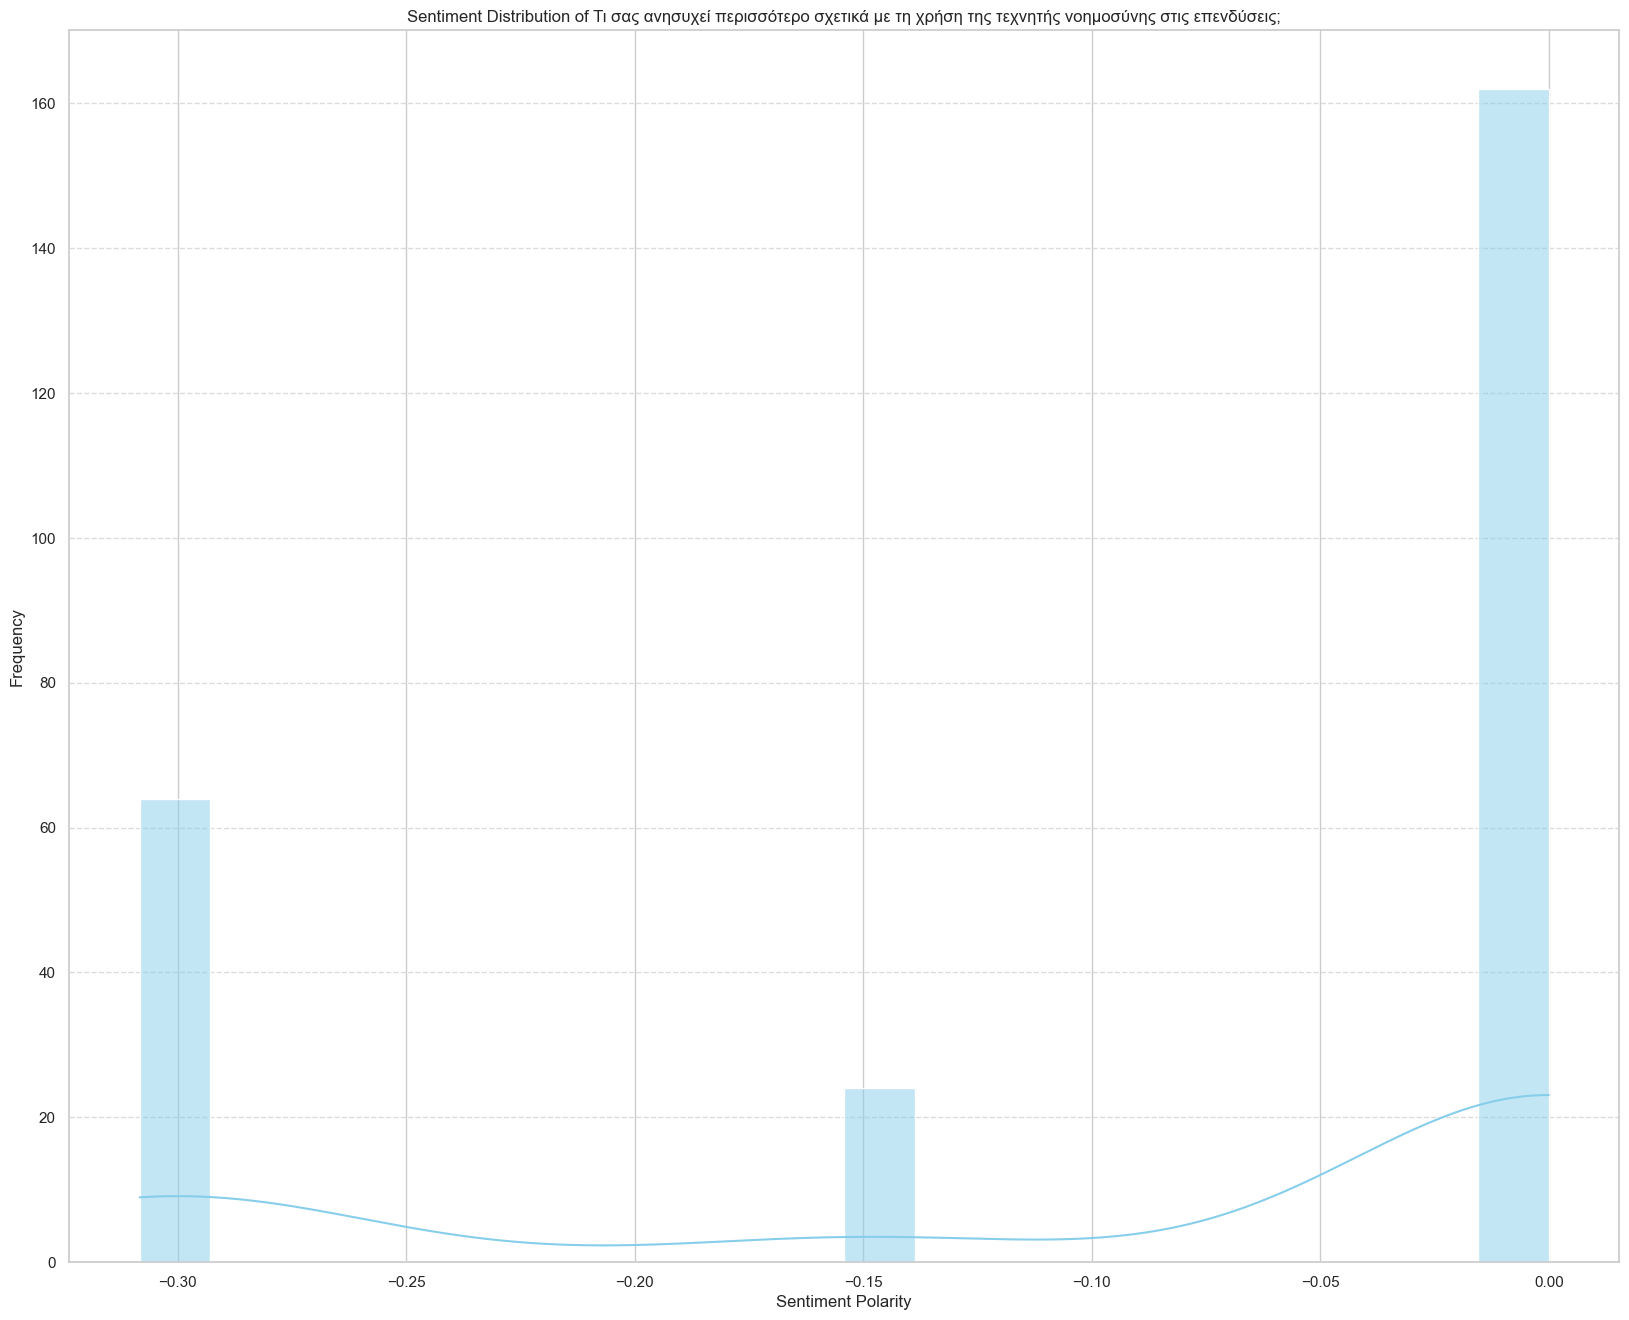

In [37]:
def translate_text_deep(text_series, src_lang="el", target_lang="en"):
    """
    Translates a Pandas Series of text from Greek to English using deep-translator.
    """
    translator = GoogleTranslator(source=src_lang, target=target_lang)
    translated = text_series.apply(lambda x: translator.translate(str(x)) if pd.notna(x) else "")
    return translated

def analyze_sentiment_with_translation_deep(text_series, column_name="Open-Ended Responses"):
    """
    Analyzes the sentiment of open-ended responses by translating to English and using TextBlob.

    Parameters:
    - text_series: pd.Series containing textual input_data.
    - column_name: str, the name of the column for better output labels.

    Returns:
    - sentiments: pd.Series of sentiment polarity scores.
    """
    # Translate text to English
    print(f"Translating '{column_name}' to English...")
    text_translated = translate_text_deep(text_series)

    # Compute sentiment polarity
    sentiments = text_translated.apply(lambda x: TextBlob(x).sentiment.polarity)

    # Print sentiment statistics
    print(f"Sentiment Analysis Results for '{column_name}':")
    print(sentiments.describe())

    # Plot sentiment distribution
    plt.figure(figsize=(20, 16))
    sns.histplot(sentiments, bins=20, kde=True, color="skyblue")
    plt.title(f"Sentiment Distribution of {column_name}")
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    return sentiments

# List of open-ended questions
open_ended_questions = [
    "Τι πιστεύετε ότι είναι το μεγαλύτερο πλεονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;",
    "Ποιο θεωρείτε το μεγαλύτερο μειονέκτημα της τεχνητής νοημοσύνης στις επενδύσεις;",
    "Τι σας ανησυχεί περισσότερο σχετικά με τη χρήση της τεχνητής νοημοσύνης στις επενδύσεις;"
]

# Perform sentiment analysis for each open-ended question
for question in open_ended_questions:
    if question in data.columns:
        print(f"\nAnalyzing sentiment for: {question}")
        sentiments = analyze_sentiment_with_translation_deep(data[question], column_name=question)
    else:
        print(f"Question '{question}' not found in dataset.")

In [38]:
def perform_anova(input_data, group_col, response_col):
    """
    Performs ANOVA to test for differences in responses across groups.

    Parameters:
    - input_data: pd.DataFrame containing the input_data.
    - group_col: str, the column to group by (categorical variable).
    - response_col: str, the column containing the numeric response variable.

    Returns:
    - None. Prints ANOVA results.
    """
    print(f"Analyzing ANOVA for Group Column: '{group_col}' and Response Column: '{response_col}'\n")

    # Ensure group_col and response_col exist in the dataset
    if group_col not in input_data.columns or response_col not in input_data.columns:
        print(f"Error: Columns '{group_col}' or '{response_col}' not found in dataset.")
        return

    # Ensure response_col is numeric
    if not pd.api.types.is_numeric_dtype(input_data[response_col]):
        print(f"Error: Response column '{response_col}' is not numeric. Please map it to numeric values first.")
        print(f"Sample Data:\n{input_data[response_col].head()}")
        return

    # Filter valid groups and drop NaN values
    valid_data = input_data[[group_col, response_col]].dropna()
    print(f"Valid input_data after dropping NaNs:\n{valid_data.head()}\n")
    print(f"Total valid rows: {len(valid_data)}")

    # Count the number of valid responses per group
    group_sizes = valid_data[group_col].value_counts()
    print(f"Group sizes:\n{group_sizes}\n")

    # Ensure at least two groups with sufficient input_data (at least 2 responses per group)
    sufficient_groups = group_sizes[group_sizes >= 2].index
    print(f"Sufficient groups for ANOVA: {sufficient_groups}\n")

    if len(sufficient_groups) < 2:
        print(f"Error: Not enough valid groups in '{group_col}' for ANOVA.")
        return

    # Filter valid input_data to include only sufficient groups
    valid_data = valid_data[valid_data[group_col].isin(sufficient_groups)]

    # Prepare group input_data for ANOVA
    groups = [valid_data.loc[valid_data[group_col] == group, response_col] for group in sufficient_groups]

    for i, group in enumerate(sufficient_groups):
        print(f"Group '{group}' input_data (size {len(groups[i])}):\n{groups[i].head()}\n")

    # Perform ANOVA
    try:
        f_stat, p_value = f_oneway(*groups)
        print(f"ANOVA Results for '{response_col}' by '{group_col}':")
        print(f"F-Statistic: {f_stat:.3f}, P-Value: {p_value:.5f}")

        if p_value < 0.05:
            print("Conclusion: There are significant differences between groups.")
        else:
            print("Conclusion: No significant differences between groups.")
    except Exception as e:
        print(f"Error during ANOVA analysis: {e}")

# Define columns
group_column = 'Ποιο είναι το φύλο σας;'
response_column = 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;'

# Map response column to numeric values
response_mapping = {
    'Όχι': 1,
    'Ίσως': 2,
    'Ναι': 3
}
data[response_column] = data[response_column].map(response_mapping)

# Drop rows with NaN in group or response columns
data.dropna(subset=[group_column, response_column], inplace=True)

# Perform ANOVA
if group_column in data.columns and response_column in data.columns:
    perform_anova(data, group_column, response_column)
else:
    print(f"Group or response columns not found in dataset.")

Analyzing ANOVA for Group Column: 'Ποιο είναι το φύλο σας;' and Response Column: 'Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;'

Valid input_data after dropping NaNs:
Empty DataFrame
Columns: [Ποιο είναι το φύλο σας;, Θα εμπιστευόσασταν ένα μοντέλο τεχνητής νοημοσύνης να διαχειριστεί εξ ολοκλήρου τις επενδύσεις σας;]
Index: []

Total valid rows: 0
Group sizes:
Series([], Name: count, dtype: int64)

Sufficient groups for ANOVA: Index([], dtype='object', name='Ποιο είναι το φύλο σας;')

Error: Not enough valid groups in 'Ποιο είναι το φύλο σας;' for ANOVA.


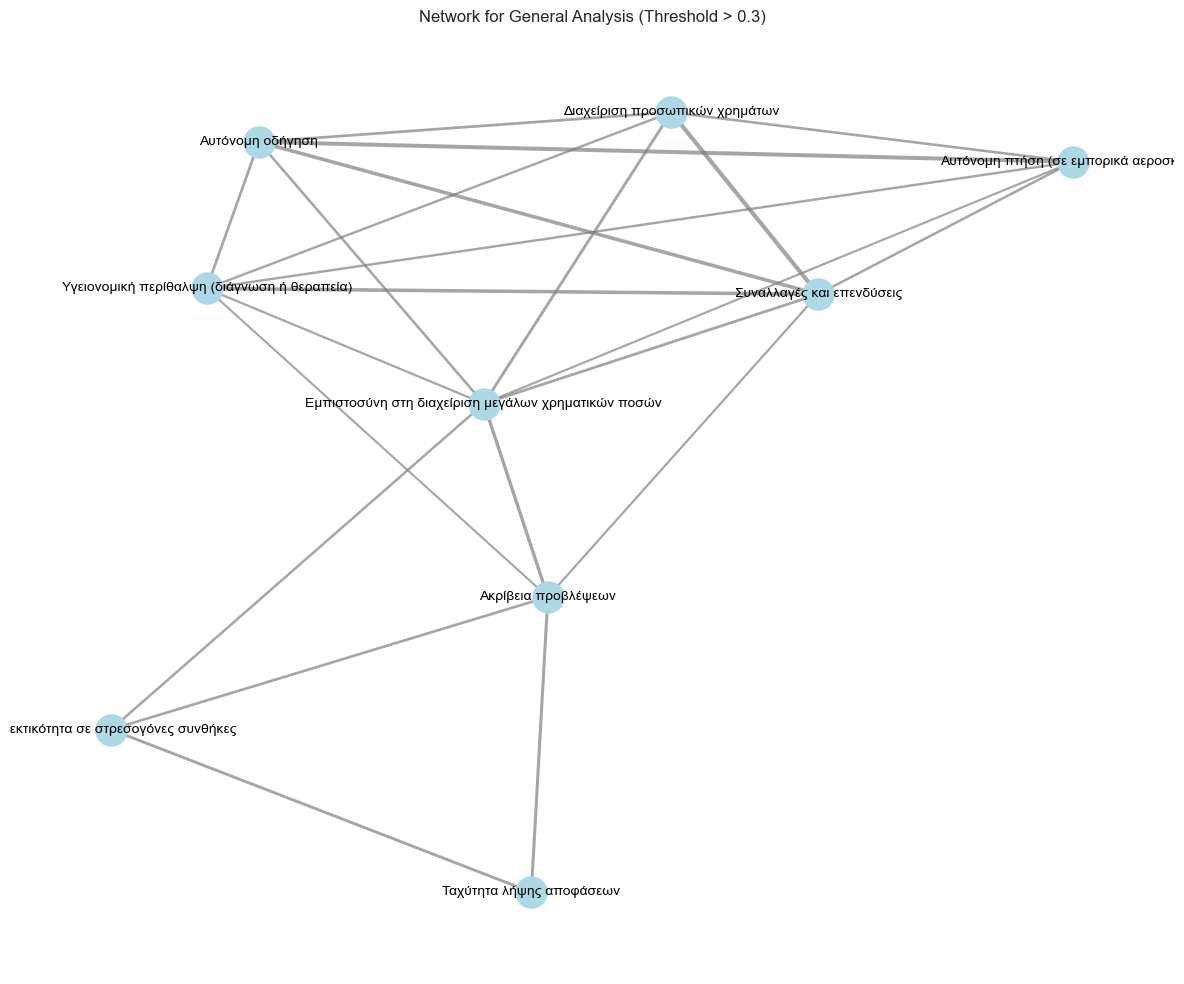

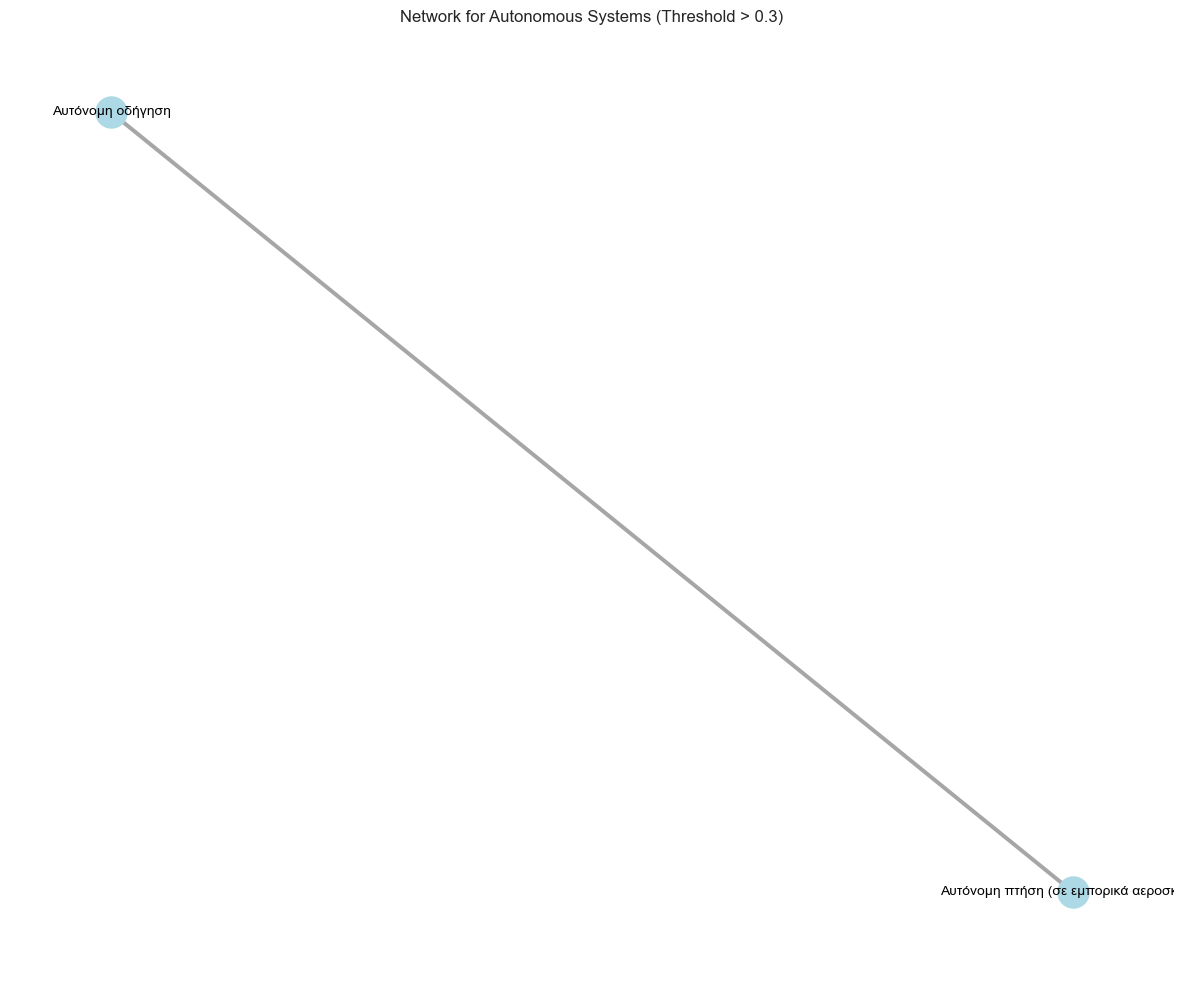

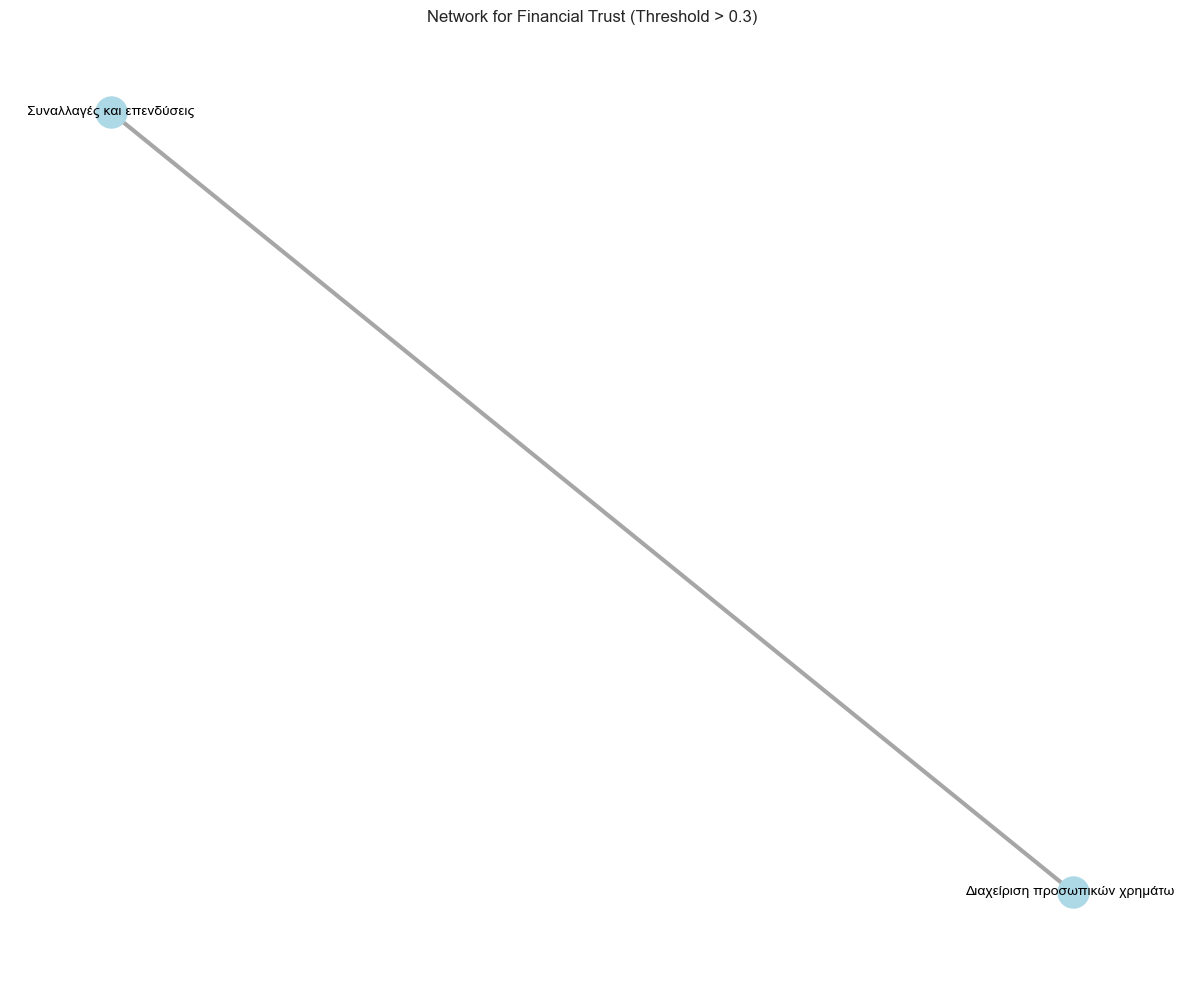

In [47]:
def perform_network_analysis(input_data, threshold=0.3, category=None):
    """
    Performs network analysis to visualize relationships between questions based on correlation.

    Parameters:
    - input_data: pd.DataFrame, numeric input_data for correlation analysis.
    - threshold: float, absolute correlation value above which an edge is created.
    - category: str, optional category name to customize graph title.

    Returns:
    - None. Displays a network graph.
    """
    # Calculate the correlation matrix
    corr_matrix = input_data.corr()

    # Create a graph
    G = nx.Graph()

    # Add edges based on the correlation threshold
    for i, col1 in enumerate(corr_matrix.columns):
        for j, col2 in enumerate(corr_matrix.columns):
            if i < j and abs(corr_matrix.iloc[i, j]) > threshold:
                G.add_edge(col1, col2, weight=corr_matrix.iloc[i, j])

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
    edges = G.edges(data=True)

    # Edge weights influence edge thickness
    edge_widths = [abs(edge_data['weight']) * 5 for _, _, edge_data in edges]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Add title
    title = f"Network Analysis of Questionnaire Responses"
    if category:
        title = f"Network for {category} (Threshold > {threshold})"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]

# Perform network analysis with adjusted threshold and categories
if len(numeric_cols) > 1:
    perform_network_analysis(data[numeric_cols], threshold=0.3, category="General Analysis")
    perform_network_analysis(data[['Αυτόνομη οδήγηση', 'Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)']],
                             threshold=0.3, category="Autonomous Systems")
    perform_network_analysis(data[['Συναλλαγές και επενδύσεις', 'Διαχείριση προσωπικών χρημάτων']],
                             threshold=0.3, category="Financial Trust")
else:
    print("Not enough numeric columns for network analysis.")

Correlation Matrix:
                                                    Αυτόνομη οδήγηση  \
Αυτόνομη οδήγηση                                            1.000000   
Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)                      0.574387   
Υγειονομική περίθαλψη (διάγνωση ή θεραπεία)                 0.392448   
Συναλλαγές και επενδύσεις                                   0.519829   
Διαχείριση προσωπικών χρημάτων                              0.391189   
Ταχύτητα λήψης αποφάσεων                                    0.220118   
Ακρίβεια προβλέψεων                                         0.253494   
Ανθεκτικότητα σε στρεσογόνες συνθήκες                       0.117722   
Εμπιστοσύνη στη διαχείριση μεγάλων χρηματικών π...          0.369978   

                                                    Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)  \
Αυτόνομη οδήγηση                                                                  0.574387   
Αυτόνομη πτήση (σε εμπορικά αεροσκάφη)                                 

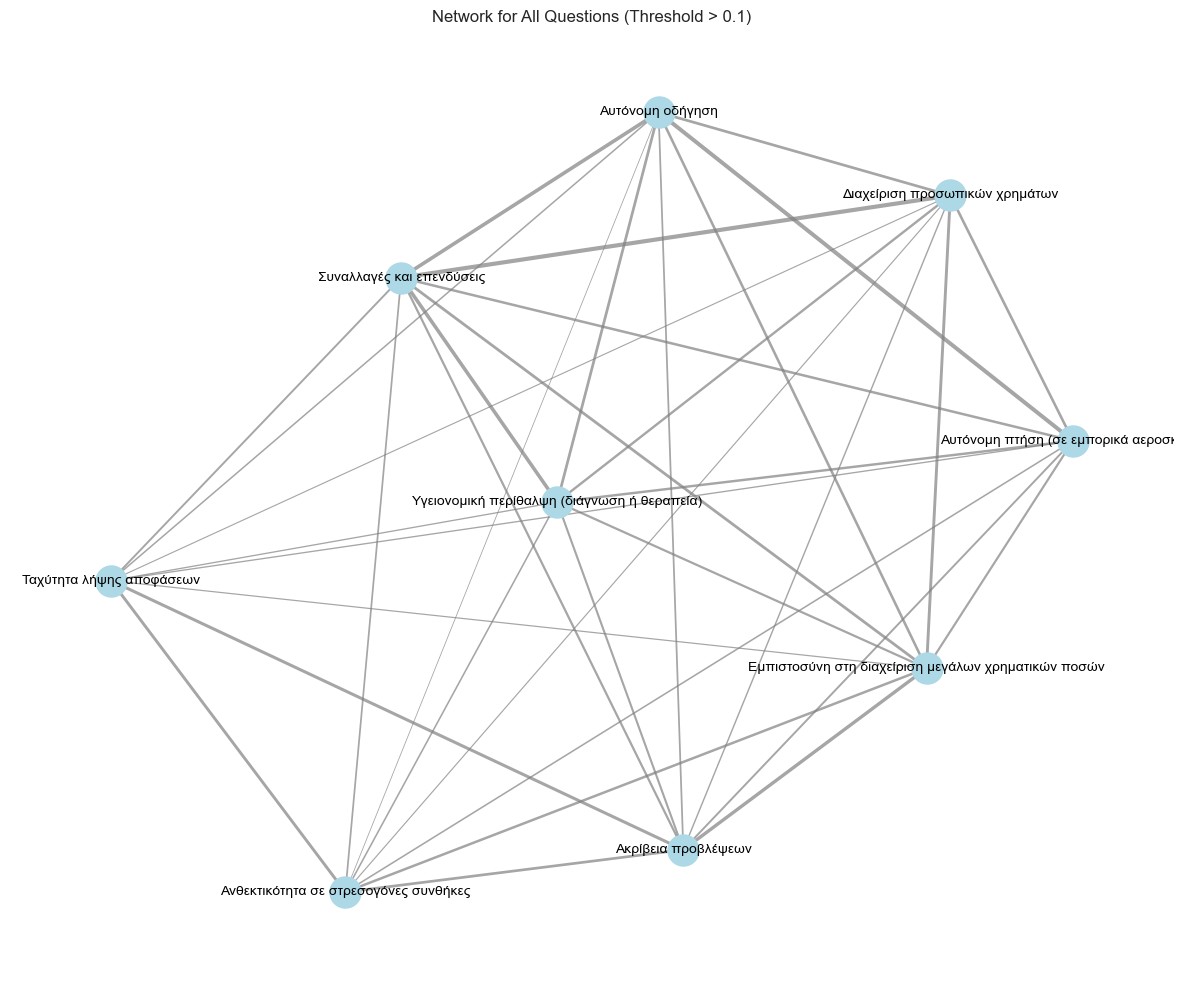

In [46]:
def perform_network_analysis(input_data, threshold=0.1, standardize=False, category=None):
    """
    Performs network analysis to visualize relationships between questions based on correlation.

    Parameters:
    - input_data: pd.DataFrame, numeric input_data for correlation analysis.
    - threshold: float, absolute correlation value above which an edge is created.
    - standardize: bool, whether to standardize input_data before calculating correlations.
    - category: str, optional category name to customize graph title.

    Returns:
    - None. Displays a network graph.
    """
    # Optionally standardize input_data
    if standardize:
        scaler = StandardScaler()
        input_data = pd.DataFrame(scaler.fit_transform(input_data), columns=input_data.columns)

    # Calculate the correlation matrix
    corr_matrix = input_data.corr()
    print("Correlation Matrix:")
    print(corr_matrix)

    # Create a graph
    G = nx.Graph()

    # Add edges based on the correlation threshold
    for i, col1 in enumerate(corr_matrix.columns):
        for j, col2 in enumerate(corr_matrix.columns):
            if i < j and abs(corr_matrix.iloc[i, j]) > threshold:
                G.add_edge(col1, col2, weight=corr_matrix.iloc[i, j])

    # Check if the graph is empty
    if len(G.nodes) == 0:
        print(f"No edges found above the threshold {threshold}. Try lowering the threshold.")
        return

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
    edges = G.edges(data=True)

    # Edge weights influence edge thickness
    edge_widths = [abs(edge_data['weight']) * 5 for _, _, edge_data in edges]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Add title
    title = f"Network Analysis of Questionnaire Responses"
    if category:
        title = f"Network for {category} (Threshold > {threshold})"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
numeric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]

# Perform network analysis with adjusted threshold and debugging
if len(numeric_cols) > 1:
    perform_network_analysis(data[numeric_cols], threshold=0.1, standardize=True, category="All Questions")
else:
    print("Not enough numeric columns for network analysis.")